In [2]:
# %%
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import ast

from src.wimbd_ import BasePaths as PATHS, Colors
from src.wimbd_ import DataConfigs as CONFIG
from src.wimbd_ import post_filter, filter_percentile, load_results
from src.wimbd_ import ProcessTriviaQA as ptqa
from src.utils import remove_nested_lists, softmax
from src.analysis import AnalyzeNgrams as an

from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Generate a timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H:%M")


[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[dynet] random seed: 1234
[dynet] allocating memory: 32MB
[dynet] memory allocation done.


In [3]:
# %%
task_coverage_pth = "./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaFalse/3/common/task-p-coverage.pkl"
task_coverage = pd.read_pickle(task_coverage_pth)


In [32]:
# %%
all_models = ['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b', 'pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m']
large_models = ['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b']
small_models = ['pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m']

N_GRAMS = 3
ALIGN_THRESH = 75
# BASE_DIR = f"./results/n-grams/trivia_qa/pile/exp_3/test-set/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaFalse/"
# BASE_DIR = f"./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaFalse"
# BASE_DIR = f"./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaFalse"
DATASET = "examples_dfs_0-shot_common_pythia_models.pkl" # "examples_dfs_4-shot_common_models.pkl"
TASKS = "mmlu"
CORPUS = "pile"
BASE_DIR = PATHS.base_ngram_paths[TASKS][CORPUS]['base_path']
OMMIT_TASKS = False
TASKS_OMMIT = ["formal_logic"]
POST_FILTER = True

# BASE_DIR = PATHS.base_ngram_paths[TASKS]['base_path']
BASE_PATH = os.path.join(BASE_DIR, f"{N_GRAMS}")
METHOD = "0-shot_common"
BASE_PATH_COMMON = os.path.join(BASE_PATH, "common")
BASE_PATH_ALL = os.path.join(BASE_PATH, "all")
# FIG_DIR = os.path.join("/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/figures", DATASET, timestamp)
# if not os.path.exists(FIG_DIR):
#     os.makedirs(FIG_DIR)

# RESULTS_PATH = os.path.join(BASE_DIR, str(N_GRAMS), 'common', DATASET)
RESULTS_PATH = os.path.join(BASE_DIR, str(N_GRAMS), DATASET)
FIGS_PTH = f"./figures/{TASKS}"

# SUB_TASKS = ['marketing', 'management', 
#              'high_school_world_history',
#              'high_school_european_history',
#              'miscellaneous']

# SUB_TASKS = ['public_relations', 'miscellaneous', 'nutrition', 'management',
#             'conceptual_physics', 'professional_psychology',
#             'high_school_us_history', 'high_school_psychology',
#             'high_school_geography', 'high_school_world_history',
#             'human_aging', 'high_school_european_history', 'virology',
#             'anatomy', 'astronomy', 'computer_security', 'marketing',
#             'logical_fallacies', 'international_law']

SUB_TASKS = None

# SUB_TASKS = ['marketing',
#              'high_school_world_history',
#              'miscellaneous']

MODELS = 'open-instruct-pythia-6.9b-tulu'



print(f"BASE PATH: {BASE_PATH}")

VIEW_COLS = ['Q', 'A', 'question', 'value', 'align_score', 'em', 'answer']


BASE PATH: ./results/n-grams/mmlu/exp3/test-set/exp_full_None/3


In [33]:
# %%
# filter outliers
pickle_file = pd.read_pickle(RESULTS_PATH)
# df = pd.DataFrame(pickle_file).T.sort_values("value", ascending=False)

# filter
# open
# examples_models_pth = os.path.join(BASE_PATH, f"examples_dfs_{METHOD}_post-processed.pkl")
examples_models_pth = RESULTS_PATH
if os.path.exists(examples_models_pth):
    with open(examples_models_pth, 'rb') as f:
        examples_models = pickle.load(f)
else:
    examples_models = ptqa.process_model_examples(pickle_file, p=0.99999)
examples_model = examples_models['pythia-12b']
colors = sns.color_palette('hls', len(examples_models))


In [34]:
pickle_file['pythia-12b']['task'].unique()

array(['miscellaneous', 'high_school_european_history', 'management',
       'anatomy', 'high_school_world_history', 'marketing',
       'international_law'], dtype=object)

In [35]:
# %%
examples_model.head()


,Q,A,value,example,task,pair,coverage,question,alignment_score,query,sum,count,id,gold,query_drop,choices,gold_drop,result
0,alliance world war,Spain,32,{'question': 'Which of these countries was not...,miscellaneous,"('alliance world war', 'Spain')",0.166998,Which of these countries was not a member of t...,80.022770,Which of these countries was not a member of t...,2407704,60,170_14,0,Which of these countries was not a member of t...,"[A, B, C, D]",2,"[-1.75390625, -1.60546875, -1.39453125, -1.488..."
1,axis alliance world,Japan,2,{'question': 'Which of these countries was not...,miscellaneous,"('axis alliance world', 'Japan')",0.166998,Which of these countries was not a member of t...,80.300410,Which of these countries was not a member of t...,2407704,60,170_14,0,Which of these countries was not a member of t...,"[A, B, C, D]",2,"[-1.75390625, -1.60546875, -1.39453125, -1.488..."
2,countries member axis,Spain,0,{'question': 'Which of these countries was not...,miscellaneous,"('countries member axis', 'Spain')",0.166998,Which of these countries was not a member of t...,83.322845,Which of these countries was not a member of t...,2407704,60,170_14,0,Which of these countries was not a member of t...,"[A, B, C, D]",2,"[-1.75390625, -1.60546875, -1.39453125, -1.488..."
3,alliance world war,Germany,55,{'question': 'Which of these countries was not...,miscellaneous,"('alliance world war', 'Germany')",0.166998,Which of these countries was not a member of t...,80.022770,Which of these countries was not a member of t...,2407704,60,170_14,0,Which of these countries was not a member of t...,"[A, B, C, D]",2,"[-1.75390625, -1.60546875, -1.39453125, -1.488..."
4,alliance world war,Italy,42,{'question': 'Which of these countries was not...,miscellaneous,"('alliance world war', 'Italy')",0.166998,Which of these countries was not a member of t...,80.022770,Which of these countries was not a member of t...,2407704,60,170_14,0,Which of these countries was not a member of t...,"[A, B, C, D]",2,"[-1.75390625, -1.60546875, -1.39453125, -1.488..."


In [36]:
# %%
def filter_correct_choices(df):
    def is_correct_choice(row):
        example = row['example']
        if isinstance(example, str):
            example = ast.literal_eval(example)
        choices = example['choices']
        answer_index = example['answer']
        correct_answer = choices[answer_index]
        return row['A'] == correct_answer
    
    filtered_df = df[df.progress_apply(is_correct_choice, axis=1)]
    return filtered_df

def add_accuracy_column(df):
    def is_correct_answer(row):
        example = row['example']
        if isinstance(example, str):
            example = ast.literal_eval(example)
        answer_index = example['answer']
        result = row['result']
        if isinstance(result, str):
            result = ast.literal_eval(result)
        predicted_index = np.argmax(result)
        return int(predicted_index == answer_index)

    df['accuracy'] = df.progress_apply(is_correct_answer, axis=1)
    return df

examples_models = {MODELS: examples_models[MODELS]}
# examples_models = {task: examples_models[examples_models['task'] == task] for task in examples_models['task'].unique() if task in SUB_TASKS}
examples_models = {k: filter_correct_choices(v) for k, v in examples_models.items()}
examples_models = {k: add_accuracy_column(v) for k, v in examples_models.items()}

# # save 
# examples_models_correct_pth = os.path.join(BASE_PATH, f"examples_dfs_{METHOD}_post-processed.pkl")
# with open(examples_models_correct_pth, 'wb') as f:
#     pickle.dump(examples_models, f)



  0%|          | 0/263256 [00:00<?, ?it/s]

100%|██████████| 65763/65763 [00:03<00:00, 18656.57it/s]


In [37]:
# # %%
# examples_models_correct_pth = os.path.join(BASE_PATH, f"examples_dfs_{METHOD}_post-processed-aligned.pkl")
# if os.path.exists(examples_models_correct_pth):
#     with open(examples_models_correct_pth, 'rb') as f:
#         examples_models = pickle.load(f)
# else:
from src.wimbd_ import align_e5_pairs_df

examples_models = {k: align_e5_pairs_df(df, 'Q', 'question') for k, df in examples_models.items()}

# # save
# with open(examples_models_correct_pth, 'wb') as f:
#     pickle.dump(examples_models, f)


Using device: cuda


Aligning pairs:   0%|          | 0/65763 [00:00<?, ?it/s]

Processing row 0


Aligning pairs:   0%|          | 0/65763 [28:42<?, ?it/s]


In [38]:
# save
with open(os.path.join(BASE_PATH, f"examples_dfs_{METHOD}_post-processed.pkl"), 'wb') as f:
    pickle.dump(examples_models, f)


In [18]:
# %%
examples_models['open-instruct-pythia-6.9b-tulu'].head()


,Q,A,value,example,task,pair,coverage,question,alignment_score,query,sum,count,id,gold,query_drop,choices,gold_drop,result,accuracy
1,objective,Broad,603129,{'question': 'Which of these should an objecti...,public_relations,"(objective, Broad)",0.001609,Which of these should an objective NOT be?,80.191338,Which of these should an objective NOT be?,812800,4,106_17,0,Which of these should an objective NOT be?\nA....,"[A, B, C, D]",0,"[-2.060636043548584, -1.0321813821792603, -1.3...",0
4,virus,Chicken pox,8794,"{'question': 'Which of these is a virus?', 'ch...",miscellaneous,"('virus', 'Chicken pox')",0.025744,Which of these is a virus?,86.200790,Which of these is a virus?,166595,4,26_14,0,Which of these is a virus?\nA. Staphylococcus\...,"[A, B, C, D]",3,"[-1.171823501586914, -1.3485488891601562, -1.8...",0
11,histones,Proteins,62656,"{'question': 'What are histones? ', 'choices':...",nutrition,"(histones, Proteins)",0.007558,What are histones?\n,90.503082,What are histones?\n,80543,4,232_15,0,What are histones?\nA. Lipids\nB. Carbohydrate...,"[A, B, C, D]",3,"[-3.0945048332214355, -2.4091334342956543, -0....",0
13,spice,cucumber,29739,"{'question': 'Which of these is not a spice?',...",miscellaneous,"('spice', 'cucumber')",0.025744,Which of these is not a spice?,82.105064,Which of these is not a spice?,78161,4,563_14,0,Which of these is not a spice?\nA. dill\nB. an...,"[A, B, C, D]",2,"[-2.097806453704834, -1.0631023645401, -1.3930...",0
16,legumes,radishes,5418,{'question': 'Which of these are not legumes?'...,miscellaneous,"('legumes', 'radishes')",0.025744,Which of these are not legumes?,81.906601,Which of these are not legumes?,73517,4,359_14,0,Which of these are not legumes?\nA. beans\nB. ...,"[A, B, C, D]",2,"[-0.9904704093933105, -1.4415812492370605, -1....",0


In [19]:
# %%
from src.analysis import AnalyzeNgrams as an

# coverage_path = os.path.join(BASE_PATH_COMMON, "task-coverage.pkl")
# task_cov = an.calculate_average_task_coverage(BASE_PATH_ALL, [TASKS], [N_GRAMS])


In [20]:
# %%
examples_models_ = {model: data[data['alignment_score'] > ALIGN_THRESH] for model, data in examples_models.items()}
# examples_models_['high_school_european_history'].head(20)


In [13]:
# %%
examples_models_tasks = {task: examples_models['open-instruct-pythia-6.9b-tulu'][examples_models['open-instruct-pythia-6.9b-tulu']['task'] == task] for task in examples_models['open-instruct-pythia-6.9b-tulu']['task'].unique()}


Processing: public_relations
interval
[-1.0000, 4.0500)    786
[100, ∞)               1
Name: count, dtype: int64
avg_df =                    interval_start    avg_y
interval                                  
[-1.0000, 4.0500)             1.0  0.37659
[100, ∞)                    100.0  0.00000
avg_y: interval
[-1.0000, 4.0500)    0.37659
[100, ∞)             0.00000
Name: avg_y, dtype: float64
Processing: miscellaneous
interval
[-1.0000, 4.0500)     3252
[100, ∞)                14
[4.0500, 9.1000)        13
[19.2000, 24.2500)       4
[44.4500, 49.5000)       2
[9.1000, 14.1500)        2
[49.5000, 54.5500)       1
[89.9000, 94.9500)       1
[69.7000, 74.7500)       1
[34.3500, 39.4000)       1
[29.3000, 34.3500)       1
Name: count, dtype: int64
avg_df =                     interval_start     avg_y
interval                                    
[-1.0000, 4.0500)             1.00  0.429582
[4.0500, 9.1000)              4.05  0.538462
[9.1000, 14.1500)             9.10  0.500000
[19.2000, 2

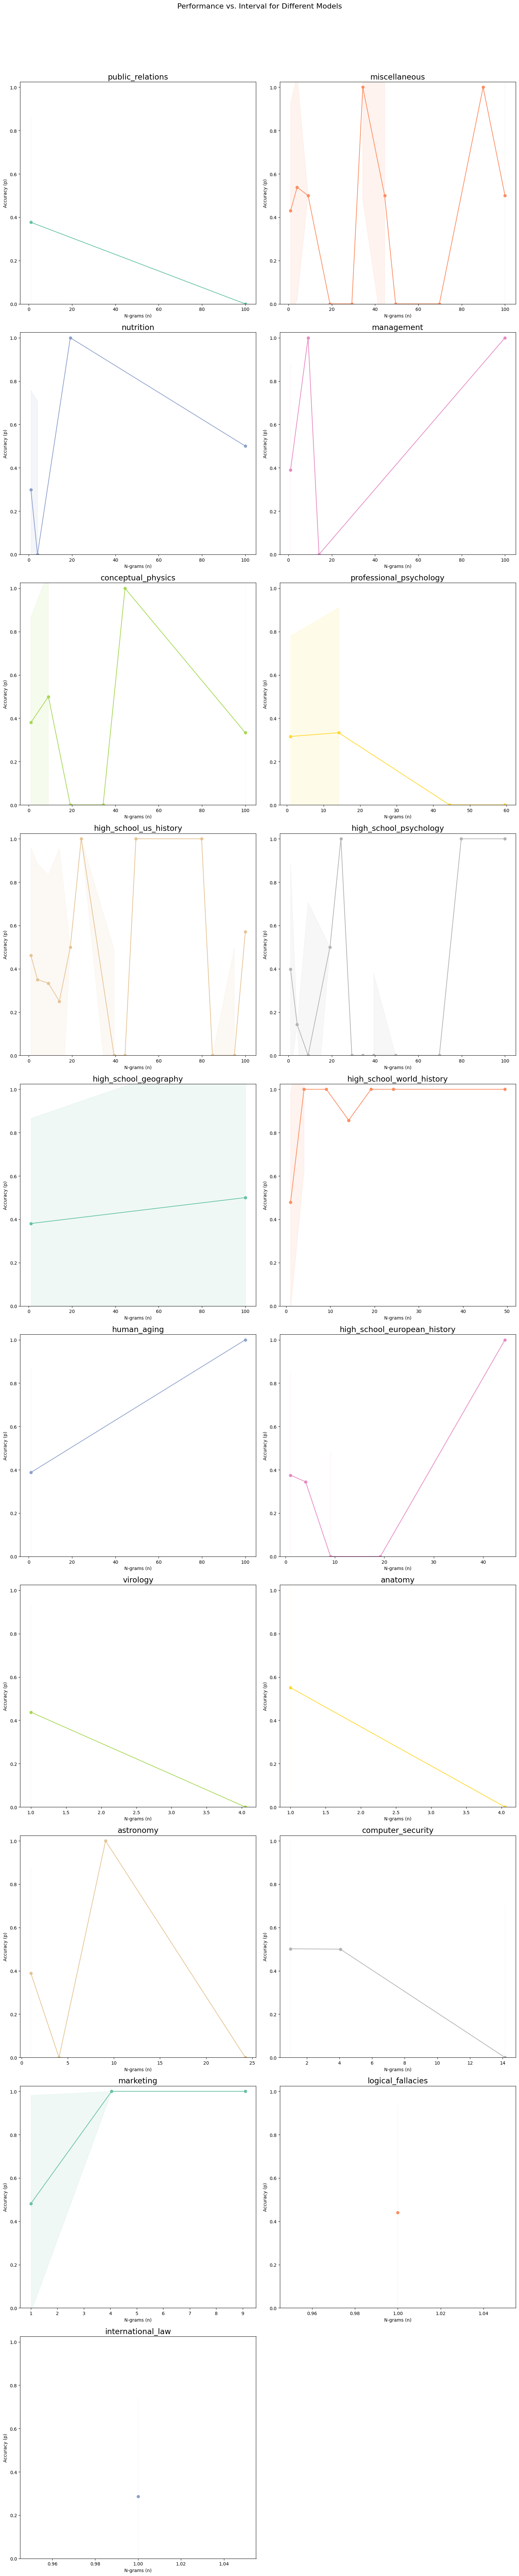

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

# Determine the number of rows and columns for the subplots
n_models = len(examples_models_tasks)
n_cols = 2  # You can adjust this as needed
n_rows = math.ceil(n_models / n_cols)

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 8*n_rows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# color palette
color_palette = sns.color_palette('Set2', n_models)

is_log = False
plot_var = 'value'
savefile = os.path.join(FIGS_PTH, f"avg_em_by_log_interval_all_log{is_log}_{plot_var}_aligned{ALIGN_THRESH}.pdf")

for i, (model_name, data) in enumerate(examples_models_tasks.items()):
    print(f"Processing: {model_name}")
    data = an.create_bins(data, plot_var, -1, 100, 20, is_log)
    
    # Get the current axis
    ax = axes[i]
    
    # Plot on the current axis
    ptqa.plot_variable_by_interval(data, log_axis=is_log,
                                   x_column='interval', y_column='accuracy',
                                   save_pth=None,  # We'll save the entire figure later
                                   ax=ax, 
                                   color=color_palette[i], label=model_name,
                                   plot_std=True, ylimits=[0,1.025])
    
    # Set the title for each subplot
    ax.set_title(model_name)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout and add a main title
plt.tight_layout()
fig.suptitle(f'Performance vs. Interval for Different Models', fontsize=16)
plt.subplots_adjust(top=0.95)  # Adjust this value to prevent the main title from overlapping with subplots

# Save the entire figure
plt.savefig(savefile)
plt.show()

Processing: public_relations
Processing: miscellaneous
Processing: nutrition
Processing: management
Processing: conceptual_physics
Processing: professional_psychology
Processing: high_school_us_history
Processing: high_school_psychology
Processing: high_school_geography


/tmp/ipykernel_1615593/2424375850.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_covered'] = data['value'] > 0
/tmp/ipykernel_1615593/2424375850.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['False', 'True'])
/tmp/ipykernel_1615593/2424375850.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_covered'] = data['value'] > 0
/tmp/ipykernel_1615593/2424375850.py:39: UserWarning: FixedFormatter should only be used together with F

Processing: high_school_world_history
Processing: human_aging
Processing: high_school_european_history
Processing: virology
Processing: anatomy
Processing: astronomy
Processing: computer_security
Processing: marketing
Processing: logical_fallacies
Processing: international_law


/tmp/ipykernel_1615593/2424375850.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['False', 'True'])
/tmp/ipykernel_1615593/2424375850.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_covered'] = data['value'] > 0
/tmp/ipykernel_1615593/2424375850.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['False', 'True'])
/tmp/ipykernel_1615593/2424375850.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  avg_ax.set_xticklabels(['False', 'True'])


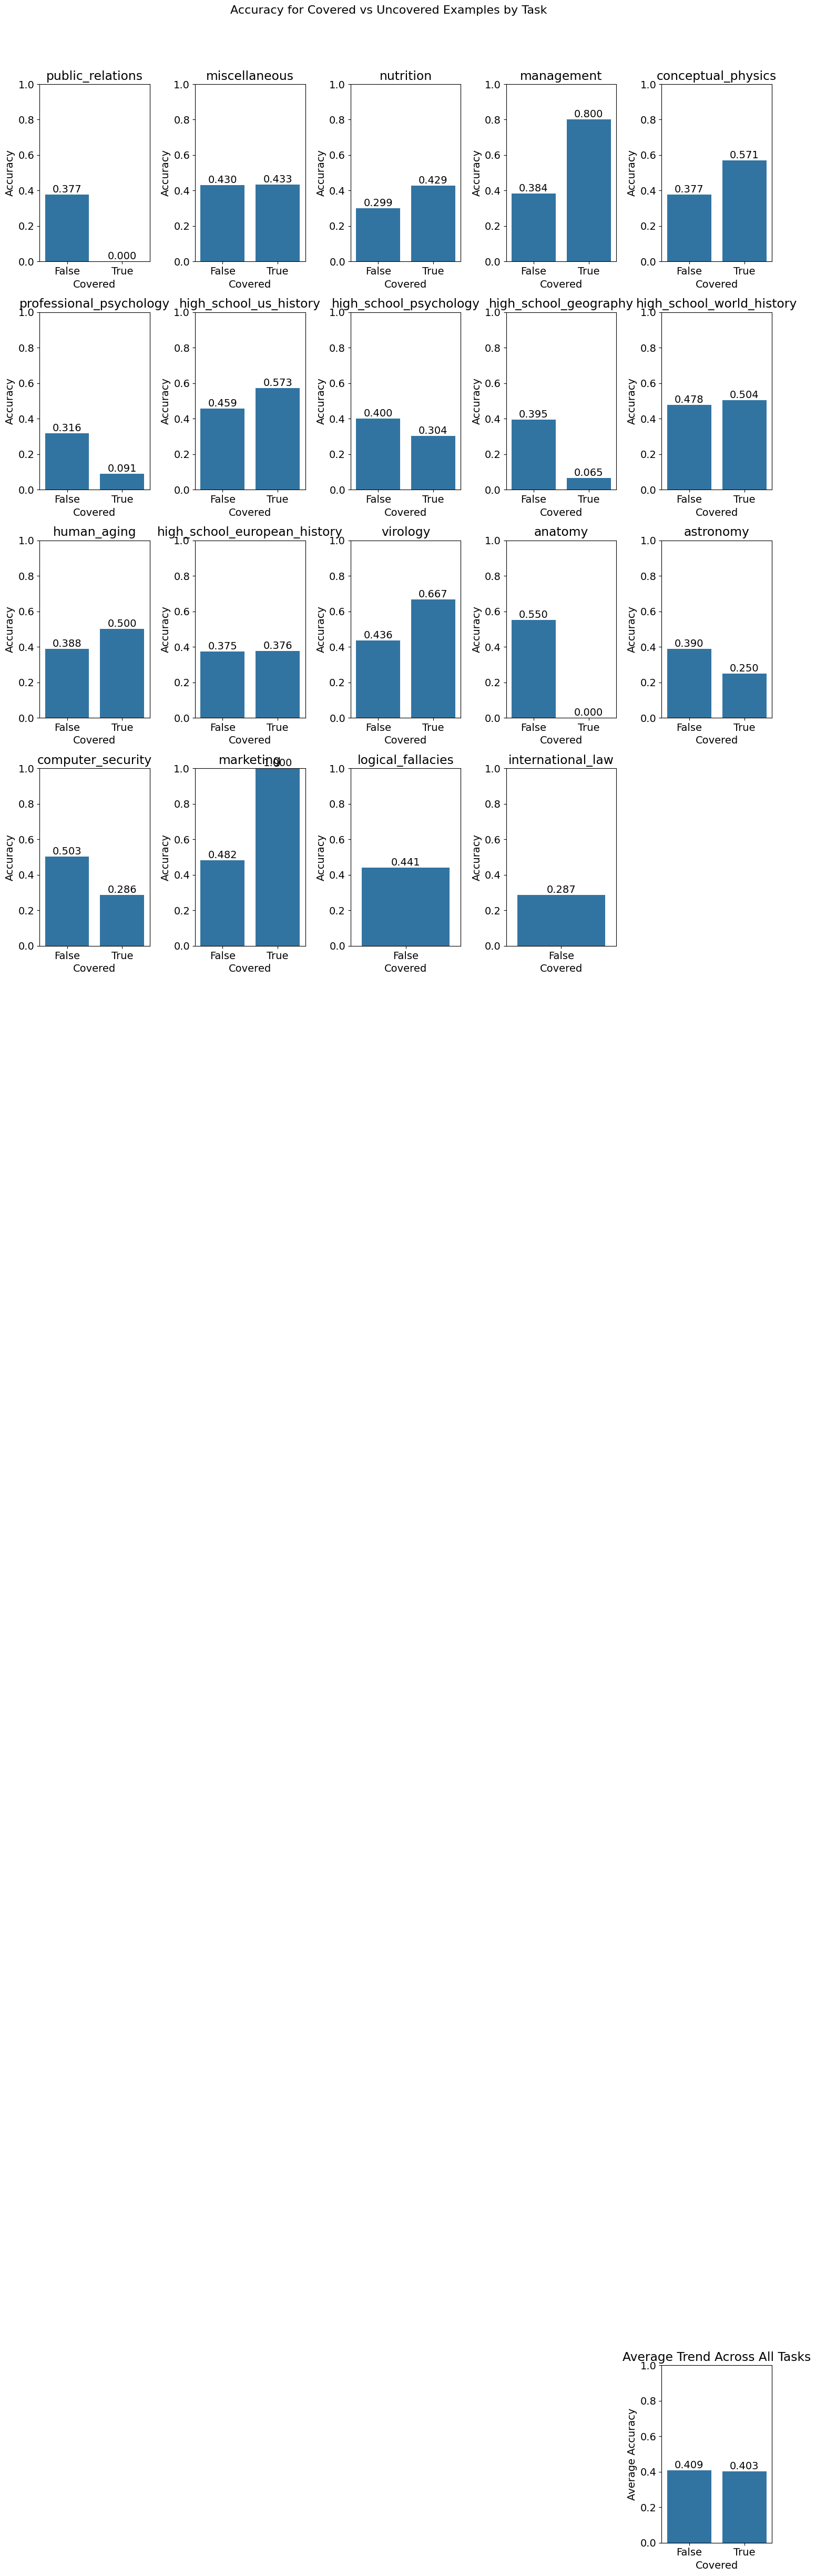

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

def plot_coverage_accuracy(examples_models_tasks, figsize=(15, 50)):
    # Determine the number of rows and columns for the subplots
    n_tasks = len(examples_models_tasks)
    n_cols = 4  # You can adjust this as needed
    n_cols = math.ceil(n_tasks / n_cols)

    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows + 1, n_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    all_grouped_data = []

    for i, (task_name, data) in enumerate(examples_models_tasks.items()):
        print(f"Processing: {task_name}")
        
        # Create a boolean column for coverage
        data['is_covered'] = data['value'] > 0
        
        # Group by coverage and calculate mean accuracy
        grouped_data = data.groupby('is_covered')['accuracy'].mean().reset_index()
        all_grouped_data.append(grouped_data)
        
        # Get the current axis
        ax = axes[i]
        
        # Create the bar plot
        sns.barplot(x='is_covered', y='accuracy', data=grouped_data, ax=ax)
        
        # Customize the plot
        ax.set_title(task_name)
        ax.set_xlabel('Covered')
        ax.set_ylabel('Accuracy')
        ax.set_xticklabels(['False', 'True'])
        ax.set_ylim(0, 1)  # Set y-axis limits from 0 to 1
        
        # Add value labels on top of each bar
        for j, v in enumerate(grouped_data['accuracy']):
            ax.text(j, v, f'{v:.3f}', ha='center', va='bottom')

    # Remove any unused subplots for individual tasks
    for j in range(i+1, len(axes) - 1):
        fig.delaxes(axes[j])

    # Create average trend plot
    avg_ax = axes[-1]
    avg_data = pd.concat(all_grouped_data).groupby('is_covered')['accuracy'].mean().reset_index()
    sns.barplot(x='is_covered', y='accuracy', data=avg_data, ax=avg_ax)
    
    # Customize the average trend plot
    avg_ax.set_title('Average Trend Across All Tasks')
    avg_ax.set_xlabel('Covered')
    avg_ax.set_ylabel('Average Accuracy')
    avg_ax.set_xticklabels(['False', 'True'])
    avg_ax.set_ylim(0, 1)
    
    # Add value labels on top of each bar for the average trend
    for j, v in enumerate(avg_data['accuracy']):
        avg_ax.text(j, v, f'{v:.3f}', ha='center', va='bottom')

    # Adjust the layout and add a main title
    plt.tight_layout()
    fig.suptitle('Accuracy for Covered vs Uncovered Examples by Task', fontsize=16)
    plt.subplots_adjust(top=0.95)  # Adjust this value to prevent the main title from overlapping with subplots

    return fig

# Usage
fig = plot_coverage_accuracy(examples_models_tasks)
plt.show()

# Save the figure if needed
# fig.savefig('coverage_accuracy_by_task_with_average.pdf', bbox_inches='tight')

name: public_relations
Skipping public_relations due to only one value
name: miscellaneous
Values: [8794 29739 5418 23673 3553 848 7311 2 520 1568 878 116 0 24 1 211 332 121
 49 7 20 52 4 91 46 73 23 14 38 21 32 8 5 9 13 3]


TypeError: Could not convert virusspicelegumesproletariatfishfabriclouvre museumdutch ovencountries europehalluxforce equals mass timesone mineralgdp defined ratio nominal gdpdomestic product gdp defined ratioproduct gdp defined ratio nominalreal gross domestic product gdpgross domestic product gdp definedcolor rubybalalaikachicago sevenfirst american spacebreed catsnakes poisonous500 billbig berthacharacter played woody allen 1967played woody allen 1967 jamesallen 1967 james bond film1967 james bond film casinojames bond film casino royalewoody allen 1967 james bondname character played woody allenfederal national mortgage association knownnickname federal national mortgage associationvaricellakind flying contraption featured moviecontraption featured movie chitty chittymovie chitty chitty bang bangflying contraption featured movie chittyfeatured movie chitty chitty bangtraditional greek dishshaddockteam world seriescapital new zealandandromedapita typecharlie mccarthyphrase e pluribus unum meanlatin phrase e pluribus unumshow mystery science theater 3000tv show mystery science theatermystery science theater 3000 knownfans tv show mystery scienceherpetologists studystyle shoeinnings regular major league baseballmany innings regular major leagueregular major league baseball gamecareer hit leader among playersleader among players never electedhit leader among players neveramong players never elected baseballsplayers never elected baseballs hallnever elected baseballs hall famewords adverbchicken first domesticatedstar tv show everybody lovestv show everybody loves raymondcity tvs mary tyler mooremary tyler moore show settvs mary tyler moore show1986 libyan leader muammar qaddafiline death overwhat body watermuammar qaddafi drew socalled linedrew socalled line death overwhatleader muammar qaddafi drew socalledsocalled line death overwhat bodyqaddafi drew socalled line deathlibyan leader muammar qaddafi drewpoet e e cummings namee e cummings name standinitials e e poet ee e poet e ee poet e e cummingspope immediately preceded john paulimmediately preceded john paul iiitalian design firmtype primateanimals rodentagent maxwell smarts code nameget smart tv series agenttv series agent maxwell smartssmart tv series agent maxwellseries agent maxwell smarts codeoriginal get smart tv seriesanimals lays eggswords spelled correctlylarge areas south african territorycontrolled large areas south africanareas south african territory 19thempire controlled large areas southsouth african territory 19th centurynative empire controlled large areasghirardelli square locatedofficial adolph eichmann finally capturedadolph eichmann finally captured countrynazi official adolph eichmann finally1960 nazi official adolph eichmanncountries member axis alliance worldmember axis alliance world waraxis alliance world war iijohnson play professional basketball 1999play professional basketball 1999 seasoncountry magic johnson play professionalmagic johnson play professional basketballmany digits standard visa creditdigits standard visa credit cardstandard visa credit card numbertwin sister dear abby columnistsister dear abby columnist abigaildear abby columnist abigail vanburenplayed neighbor tv sitcom hoganformer today show personality playedshow personality played neighbor tvtoday show personality played neighborneighbor tv sitcom hogan familypersonality played neighbor tv sitcomred traffic light signifies driverflashing red traffic light signifiescontain small amounts naturally occurringsmall amounts naturally occurring opiumcould contain small amounts naturallyfoods could contain small amountsbiological process replicates dnaterm chili con carne referschili con carne refers chilireligious community traditionally wear bonnetsgirls religious community traditionally wearjazz great sun ra claimgreat sun ra claim borntraditional 20th wedding anniversary giftnickname floridas controversial death rowfloridas controversial death row electriccontroversial death row electric chaircompany makes oreo cookiesactor antonio banderas native languagecompany makes perfumes called beautifulmakes perfumes called beautiful pleasurestapestry one must traditionally engageone must traditionally engage activitycreate tapestry one must traditionallyphrase hospital corners refersacronym rem standph level measureknownothingsfollowing nevadacapital north dakotalargest city pennsylvaniaevent held annually memorial daysporting event held annually memorialheld annually memorial day weekend1st 2nd 3rd place finishershorse racing term wager 1stterm wager 1st 2nd 3rd3rd place finishers specific racewager 1st 2nd 3rd place2nd 3rd place finishers specificracing term wager 1st 2ndcity state new yorkbirthstone month januarycomposed moonlight sonatahindudeitytype chili pepperhero use travel place placeanimated film aladdin device herofilm aladdin device hero usedevice hero use travel place1992 animated film aladdin devicealaddin device hero use travelpropensity consume increased 075 yearyear 1 080 year 22 based information following correct1 080 year 2 basedconsume increased 075 year 1075 year 1 080 yearassume marginal propensity consume increased080 year 2 based informationmarginal propensity consume increased 075year 2 based information followingincreased 075 year 1 080based information following correct conclusionterm used describe group fishfood warms hot food coolsfood cools stored room temperaturecold food warms hot foodwarms hot food cools storedprinciple explains cold food warmsexplains cold food warms hothot food cools stored roomatmospheric concentration following gases likelyfollowing gases likely directly affectedlikely directly affected widespread deforestationconcentration following gases likely directlygases likely directly affected widespreadfollowing words appear lewis carrollwords appear lewis carroll poemappear lewis carroll poem jabberwockyfollowing sports awardfinal word pledge allegianceworld war ii leaders yaltaone world war ii leaderswar ii leaders yalta conferenceterm offspring female donkey maletechnical term offspring female donkeyoffspring female donkey male horseannounced insane world dehumanization terrorindividual systematically obliterated allpowerful eliteway modern consciousness passage discussesterror individual systematically obliterated allpowerfulsystematically obliterated allpowerful elite keykey phrases‚äîbig brother doublethink newspeakbrother doublethink newspeak ministry peacedevoted torture‚äîburned way modern consciousnesstorture‚äîburned way modern consciousness passageworld dehumanization terror individual systematicallytruth devoted lies ministry loveobliterated allpowerful elite key phrases‚äîbigdevoted war ministry truth devotedministry peace devoted war ministryministry truth devoted lies ministrybook announced insane world dehumanizationdehumanization terror individual systematically obliteratedelite key phrases‚äîbig brother doublethinklies ministry love devoted torture‚äîburnedwar ministry truth devoted lieslove devoted torture‚äîburned way modernnewspeak ministry peace devoted warphrases‚äîbig brother doublethink newspeak ministryallpowerful elite key phrases‚äîbig brotherinsane world dehumanization terror individualdoublethink newspeak ministry peace devotedministry love devoted torture‚äîburned waypeace devoted war ministry truthdevoted lies ministry love devotedservices web site ten mileseven hardest rock powerful glacierscarved broad ushaped valley lakepassage national park services webaccessible numerous hiking trails followinglake park direct result glacialbest identifies intended audience passagevalleys wonderful waterfalls accessible numerouslake show evidence power glacierstrails following best identifies intendednearly 500 feet deep 1524glaciers carve even hardest rockpeaks surrounding lake show evidencecarved smaller hanging valleys wonderfulmiles long nearly 500 feetfollowing passage national park servicesdirect result glacial carving highwonderful waterfalls accessible numerous hikingsmaller hanging valleys wonderful waterfallssits also carved smaller hangingnumerous hiking trails following bestlargest lake park direct resultsite ten miles long nearlyweb site ten miles longmeters lake mcdonald largest lakenational park services web sitefeet deep 1524 meters lakeglaciers carved broad ushaped valleywaterfalls accessible numerous hiking trailslake mcdonald largest lake parkmcdonald largest lake park directbroad ushaped valley lake mcdonalddeep 1524 meters lake mcdonaldreading following passage national parkpark services web site tenlong nearly 500 feet deepten miles long nearly 500rock powerful glaciers carved broadlake mcdonald sits also carvedcarve even hardest rock powerfulhiking trails following best identifies500 feet deep 1524 metershigh peaks surrounding lake showpowerful glaciers carved broad ushapedvalley lake mcdonald sits alsohardest rock powerful glaciers carvedalso carved smaller hanging valleyspark direct result glacial carvingmcdonald sits also carved smallerpower glaciers carve even hardestcarving high peaks surrounding lakeglacial carving high peaks surroundingsurrounding lake show evidence powerevidence power glaciers carve evenresult glacial carving high peaksstudents reading following passage national1524 meters lake mcdonald largestshow evidence power glaciers carvefollowing best identifies intended audiencehanging valleys wonderful waterfalls accessibleushaped valley lake mcdonald sitscomposer famous writing approximately 600famous writing approximately 600 liederclass learning processes change earthslearning processes change earths surfacesurface taking bits rock soilprocesses change earths surface followingfourthgrade science class learning processessoil substances away original locationsagent gradually shapes earths surfacestudents fourthgrade science class learningexample agent gradually shapes earthssubstances away original locations depositingbits rock soil substances awayfollowing best example agent graduallyaway original locations depositing locationsshapes earths surface taking bitsrock soil substances away originalsurface following best example agentchange earths surface following besttaking bits rock soil substancesearths surface taking bits rockscience class learning processes changeearths surface following best examplebest example agent gradually shapesgradually shapes earths surface takingbusiness entity raise capital sellingentity raise capital selling equityselling equity shares public followingwant form business entity raiseform business entity raise capitalequity shares public following businessjacques hedwig reyes want formshares public following business structurescapital selling equity shares publicreyes want form business entityhedwig reyes want form businesspublic following business structures adoptraise capital selling equity sharestriangle exactly equal 180 degreesangles inside triangle exactly equalkind geometry sum angles insidesum angles inside triangle exactlygeometry sum angles inside triangleinside triangle exactly equal 180effects using tiny applications localpainter created poetic sense changinglandscape painter created poetic sensepoetic sense changing atmospheric effectsenglish landscape painter created poeticatmospheric effects using tiny applicationsartists english landscape painter createdfollowing artists english landscape paintersense changing atmospheric effects usingusing tiny applications local colorcreated poetic sense changing atmosphericchanging atmospheric effects using tinychocolate addicts gulping fudge trufflesdevour favorite works authors likepoison devour favorite works authorsauthors like chocolate addicts gulpingclaim either love loathe eithereither love loathe either avoidgulping fudge truffles author passagelike chocolate addicts gulping fudgecompares certain readers chocolate addictsaddicts gulping fudge truffles authorfudge truffles author passage comparesloathe either avoid like poisoncertain readers chocolate addicts primarilyfavorite works authors like chocolateauthor passage compares certain readerslove loathe either avoid likeeither avoid like poison devourlike poison devour favorite worksworks authors like chocolate addictsfiction readers claim either lovescience fiction readers claim eithertruffles author passage compares certainreaders chocolate addicts primarily orderavoid like poison devour favoritepassage compares certain readers chocolatereaders claim either love loathefeed fed hogs last yearhogs year assuming feed costsmajor death losses following likelyfed hogs last year returnhogs last year return 130enterprise analysis shows average returnlast year return 130 100losses following likely explanation differenceanalysis shows average return 151average return 151 100 feedstable major death losses following151 100 feed fed hogsshows average return 151 100year return 130 100 feedassuming feed costs stable majordeath losses following likely explanation100 feed fed hogs lastcosts stable major death losses130 100 feed fed hogsreturn 130 100 feed fed100 feed fed hogs yearfeed fed hogs year assumingreturn 151 100 feed fedyear assuming feed costs stablefollowing likely explanation difference returnsfeed costs stable major deathfed hogs year assuming feedgasoline tank car holds 15gallons gasoline tank many gallonsgallons gasoline needed fill tanktank car holds 15 gallonsfill tank following appropriate useuse correctly answer question shownholds 15 gallons full 77 gallons gasoline tank manytank following appropriate use correctlytank many gallons gasoline needed15 gallons full 7 gallonsappropriate use correctly answer questionfull 7 gallons gasoline tankneeded fill tank following appropriategallons full 7 gallons gasolinefollowing appropriate use correctly answergasoline tank many gallons gasolinegasoline needed fill tank followingmany gallons gasoline needed fillcar holds 15 gallons fullterm describes someone believe existencedescribes someone believe existence godconsisting pieces wood inlaid geometricartwork consisting pieces wood inlaidpieces wood inlaid geometric patternstype artwork consisting pieces woodrocks float watercharacter crush little red hairedcrush little red haired girlanimated character crush little redtraveled time machine mr peabodycartoon character traveled time machinecharacter traveled time machine mrtobacco farmers increased significantly numbercontinue last year total amountlast year total amount tobaccoindustry lot money expected continuetotal amount tobacco sold americandecline following true reason phenomenonincreased significantly number smokers countrytobacco industry lot money expectedamount tobacco sold american tobaccoexpected continue last year totalmoney expected continue last yearyear total amount tobacco soldfarmers increased significantly number smokersfollowing true reason phenomenon exceptsmokers country continued decline followingcontinued decline following true reasonlot money expected continue lastnumber smokers country continued declinecountry continued decline following truesold american tobacco farmers increasedamerican tobacco farmers increased significantlytobacco sold american tobacco farmerssignificantly number smokers country continuedfollowing best source objective informationbest source objective information prospectiveinformation prospective employer publicly tradedobjective information prospective employer publiclysource objective information prospective employertv character known da niaocharacter known da niao chinachildrens tv character known dafollowing characteristic gesture drawingnasas near spacecraft began yearlongnear spacecraft began yearlong orbitspacecraft began yearlong orbit asteroidday 2000 nasas near spacecraftvalentines day 2000 nasas near2000 nasas near spacecraft begantype meat traditional reuben sandwichsuccess franklin roosevelts new dealfranklin roosevelts new deal coalitionelectoral success franklin roosevelts newreason electoral success franklin rooseveltssignificant reason electoral success franklinfollowing significant reason electoral successroosevelts new deal coalition 1930sresearch project learned website maydomain extension site org followinglearned website may useful informationinformation domain extension site orgmay useful information domain extensionsite org following assumptions websiteuseful information domain extension siteorg following assumptions website correctproject learned website may usefulconducting research project learned websitestudent conducting research project learnedwebsite may useful information domainextension site org following assumptionsreaders chose make journey joinjourney join high wire wouldgather stories way lepidopterist hoardsrecord world exactly comes transformprism fabulous stories collected waywire would work without netdizzying instructive record world exactlypat conroy following best describesrare moths costa rican beetlesview high dizzying instructive recordexplain life invited readers choseinterpret world pat conroy followingwork without net without noiselepidopterist hoards chloroformed specimens rarefabulous stories collected way gatherjoin high wire would workexactly comes transform making passcollected way gather stories wayway gather stories way lepidopteristconroy following best describes organizationmaking pass prism fabulous storiesmake journey join high wirespecimens rare moths costa ricanchose make journey join highcomes transform making pass prismchloroformed specimens rare moths costatransform making pass prism fabulousfollowing best describes organization passageway lepidopterist hoards chloroformed specimensnoise crowd disturb view highcosta rican beetles stories likelife invited readers chose makewould work without net withoutlike vessels use interpret worldcrowd disturb view high dizzyingworld exactly comes transform makingstories way lepidopterist hoards chloroformedwrote explain life invited readersinvited readers chose make journeyhigh dizzying instructive record worldhigh wire would work withoutwithout noise crowd disturb viewwithout net without noise crowdrican beetles stories like vesselsbeginning wrote explain life invitedstories like vessels use interpretbeetles stories like vessels usevessels use interpret world patnet without noise crowd disturbuse interpret world pat conroyhoards chloroformed specimens rare mothsdisturb view high dizzying instructiveinstructive record world exactly comesworld pat conroy following bestmoths costa rican beetles storiesstories collected way gather storiespass prism fabulous stories collectedmountain mythological greek gods livename mountain mythological greek godscolors two circles mastercard logosound recording made reproduced recitationmade reproduced recitation nursery rhymerecording made reproduced recitation nurseryfirst sound recording made reproducednormal playback speed 12 longplayingplayback speed 12 longplaying recordkey write words starspangled bannerscott key write words starspangledfrancis scott key write wordswar francis scott key writenames donald ducks three nephewsappears cartoons comic strips popeyecartoons comic strips popeye sailorname baby appears cartoons comicbaby appears cartoons comic stripsmany ships columbus set sailsail initial voyage new worldset sail initial voyage newcolumbus set sail initial voyageships columbus set sail initialexxon valdez run aground marchvaldez run aground march 1989specific region would likely benefitwould likely benefit following activitiesregion would likely benefit followinglandscape within specific region wouldgeographer beginning study cultural landscapestudy cultural landscape within specificbeginning study cultural landscape withincultural landscape within specific regionwithin specific region would likelycharacter woody replace tv showwoody replace tv show cheerseisenhowers administration 1950s federal government1950s federal government promoted significantpromoted significant changes transportation uniteddwight eisenhowers administration 1950s federalgovernment promoted significant changes transportationadministration 1950s federal government promotedfederal government promoted significant changespresident dwight eisenhowers administration 1950ssignificant changes transportation united statescommonly used treat allergiessecurities firms operating united statesfollowing government regulator securities firmsregulator securities firms operating unitedgovernment regulator securities firms operatingwaters high heat capacity allowsdishes made pig intestinesmuch highway gas mileage decreasehighway gas mileage decrease heavygas mileage decrease heavy rainnumber molecules 360 grams watermolecules 360 grams water h2ocontains nearly number molecules 360o2 contains nearly number moleculesoxygen o2 contains nearly numberquantity oxygen o2 contains nearlynearly number molecules 360 grams1999 state girl scoutsjimmy buffet song margaritaville singerbuffet song margaritaville singer searchingworks sculpture displayed securely placingsculpture displayed securely placing worksfragile works sculpture displayed securelybatman tv series guest villain1960s batman tv series guestsystem would likely increase consumerfollowing actions federal reserve systemfederal reserve system would likelywould likely increase consumer spendingactions federal reserve system wouldreserve system would likely increasewhats unique skeleton keyfollowing elements metalmany ribs human bodyshow color bears big houseaccording title popular childrens tvpopular childrens tv show colortv show color bears bigtitle popular childrens tv showchildrens tv show color bears10000 straightline depreciation taken first40000 expects use 20 yearsdepreciation taken first year ownershipstraightline depreciation taken first yearexpects use 20 years tractorvalue 10000 straightline depreciation takenfarmer buys new tractor 40000salvage value 10000 straightline depreciationyears tractor salvage value 1000020 years tractor salvage valuebuys new tractor 40000 expectsnew tractor 40000 expects usetractor salvage value 10000 straightlineuse 20 years tractor salvagetractor 40000 expects use 20preaching people singing others prayingquotation describes group participation eventcounted seven ministers preaching peoplesinging others praying crying mercyaccents quotation describes group participationdescribes group participation event characteristicministers preaching people singing otherspiteous accents quotation describes groupgroup participation event characteristic followingothers praying crying mercy piteouspeople singing others praying cryingseven ministers preaching people singingmercy piteous accents quotation describespraying crying mercy piteous accentscrying mercy piteous accents quotationcataracts part body might needsomeone cataracts part body mightpart body might need operationmany employers rely temporary workersprovide flexibility times fluctuating needneed however important consideration hiringimportant consideration hiring temporary workerstimes fluctuating need however importanttemporary workers provide flexibility timesemployers rely temporary workers provideworkers provide flexibility times fluctuatinghowever important consideration hiring temporaryrely temporary workers provide flexibilityflexibility times fluctuating need howeverfluctuating need however important considerationwould likely contract salmonella poisoninglikely contract salmonella poisoning eatingsomeone would likely contract salmonellacontract salmonella poisoning eating followingenergy united states need generateunited states need generate everyoneelectrical energy united states needneed generate everyone drives electricmuch electrical energy united statesstates need generate everyone drivesgenerate everyone drives electric carssolar system formed vast rotatingvast rotating cloud gas dustastronomers proposed solar system formedproposed solar system formed vastcloud gas dust explanation knownsystem formed vast rotating cloudgas dust explanation known followingformed vast rotating cloud gasrotating cloud gas dust explanationwind speed hurricane according saffirsimpsonspeed hurricane according saffirsimpson scaleslowest wind speed hurricane accordingbands jimmy page play guitarfollowing bands jimmy page playmagazines focus natural sciencemust obtained foreigners wishing permanentlyobtained foreigners wishing permanently resideforeigners wishing permanently reside usfollowing must obtained foreigners wishingstudents forward roll following problemproblem characteristic preschoolers forward rollingforward roll following problem characteristicteaching students forward roll followingteacher teaching students forward rollfollowing problem characteristic preschoolers forwardroll following problem characteristic preschoolerspreschool teacher teaching students forwardlargest moon solar systemislam first spread indonesiaobservers argue limitation official unemploymentunemployment level fails include followingargue limitation official unemployment rateofficial unemployment rate understates truerate understates true unemployment levelunemployment rate understates true unemploymenttrue unemployment level fails includeunderstates true unemployment level failslimitation official unemployment rate understatesearths core mantle lower crustinformation structure earths core mantlestructure earths core mantle lowerprovided information structure earths corefollowing provided information structure earthsffa degree iii state ffadegree iii state ffa degreeiii state ffa degree ivdegree ii chapter ffa degreegreenhand ffa degree ii chapterchapter ffa degree iii statelocal chapter ffa greenhand ffastate ffa degree iv americanfollowing degrees awarded local chapterii chapter ffa degree iiiawarded local chapter ffa greenhandchapter ffa greenhand ffa degreeffa degree iv american ffadegree iv american ffa degreeffa greenhand ffa degree iidegrees awarded local chapter ffaffa degree ii chapter ffaproduction good generates negative externalitiesgood generates negative externalities privategenerates negative externalities private marketenglish king time american revolutioncurrency many pence make poundbritish currency many pence makegenerally cost 10 30 season5000075000 people following good estimategames game attended 5000075000 people30 season 150 games gamecost 10 30 season 150game generally cost 10 30people following good estimate ticketbaseball game generally cost 10following good estimate ticket sales150 games game attended 5000075000season 150 games game attendedtickets baseball game generally costgood estimate ticket sales revenue10 30 season 150 gamesgame attended 5000075000 people followingestimate ticket sales revenue 150attended 5000075000 people following goodsales revenue 150 games combinedticket sales revenue 150 gamesmany stars american flagclothes dryer set run 30set run 30 minutes example30 minutes example following controldryer set run 30 minutesrun 30 minutes example followingminutes example following control systemstaxable income 20 percent taxtaxable income 24 percent taxincome 20 percent tax rateperson 20000 taxable income 20income 24 percent tax ratesingle person 25000 taxable incometax rate single person 2500020 percent tax rate incomepercent tax rate income rangerate single person 25000 taxable24 percent tax rate singletax rate single person 2000020000 taxable income 20 percentrate single person 20000 taxable25000 taxable income 24 percentsingle person 20000 taxable incomepercent tax rate single personperson 25000 taxable income 24following requires use least tworequires use least two needlescharlie sheen emilio estevez relatedactors charlie sheen emilio estevezcharacter tv show friends chefsp arrival intervals minimum manymany seismic stations required uniquelystations required uniquely locate epicenterminimum many seismic stations requirednormally sp arrival intervals minimumseismic stations required uniquely locaterequired uniquely locate epicenter earthquakeintervals minimum many seismic stationsarrival intervals minimum many seismicclaims value work art determinedphilosophy claims value work artaesthetic philosophy claims value workart determined museums galleries knownwork art determined museums galleriesvalue work art determined museums1909 frederick cook claimed firstfrederick cook claimed first explorerclaimed first explorer reach locationcook claimed first explorer reachzora neale hurston associated followinghuman became lords sounds lesserlong mules brutes occupied skinssundown sun gone left footprintsbecame lords sounds lesser thingssat judgment zora neale hurstonconveniences day long mules bruteszora neale hurstons eyes watchingtongueless earless eyeless conveniences daygone skins felt powerful humanhurstons eyes watching god followseyes watching god follows peopletalk sitters tongueless earless eyelesspassed nations mouths sat judgmentskins felt powerful human becameporches beside road time heartime hear things talk sittersfollows people saw come sundownpassage zora neale hurstons eyessky time sitting porches besidemouths sat judgment zora nealewatching god follows people sawgod follows people saw comepeople saw come sundown sunlesser things passed nations mouthsthings passed nations mouths satneale hurston associated following literaryfootprints sky time sitting porchesthings talk sitters tongueless earlesseyeless conveniences day long mulessun bossman gone skins feltnations mouths sat judgment zorahear things talk sitters tonguelessbeside road time hear thingsleft footprints sky time sittinghurston associated following literary movementsbossman gone skins felt powerfulpowerful human became lords soundsmules brutes occupied skins sunneale hurstons eyes watching godsounds lesser things passed nationstime sitting porches beside roadday long mules brutes occupiedsitting porches beside road timeoccupied skins sun bossman gonelords sounds lesser things passedsaw come sundown sun goneearless eyeless conveniences day longskins sun bossman gone skinssun gone left footprints skycome sundown sun gone leftsitters tongueless earless eyeless conveniencesbrutes occupied skins sun bossmanfelt powerful human became lordsjudgment zora neale hurston associatedroad time hear things talkgone left footprints sky timemetal liquid normal atmospheric pressureliquid normal atmospheric pressure temperaturelutheran church get namemaximum depth plant roots readilywithout encountering restrictive soil layerreadily penetrate without encountering restrictivedepth plant roots readily penetrateplant roots readily penetrate withoutencountering restrictive soil layer referredpenetrate without encountering restrictive soilroots readily penetrate without encounteringamps unit measurementfound snickers candy barmovies watched homes united stateshomes united states one yearwatched homes united states onemany movies watched homes unitedapproximately many movies watched homeschildrens game color rovercolor uncle sams goateefirst american college become coeducationalline existentialist play exit hellaccording famous line existentialist playfamous line existentialist play exitfollowing breakfast cereals shaped likebreakfast cereals shaped like letterfood chain used advertising sloganfast food chain used advertisingchain used advertising slogan wheresused advertising slogan wheres beefcity known rubber capital worldcm 12 cm 09 cm1010 cm three measurements blockvalues 14 cm 12 cmcm following statements true concerning09 cm following statements truethree measurements block produced followingtrue length block wood 1010measurements block produced following valuescm three measurements block producedblock produced following values 1414 cm 12 cm 09block wood 1010 cm threecm 09 cm following statements12 cm 09 cm followingproduced following values 14 cmfollowing statements true concerning measurementswood 1010 cm three measurementsfollowing values 14 cm 12length block wood 1010 cmelements body movement audience participationmovement audience participation music projectedbest describes artwork incorporates theatricalbody movement audience participation musicartwork incorporates theatrical elements bodyincorporates theatrical elements body movementaudience participation music projected imagestheatrical elements body movement audienceterm best describes artwork incorporatesdescribes artwork incorporates theatrical elementssubstance used blood famous showerfamous shower scene movie psychoblood famous shower scene movieused blood famous shower scenesouth african political party headedafrican political party headed nelsonpolitical party headed nelson mandelaname south african political partynotices new student foreign countrykindergarten teacher notices new studentactivities best help class becometeacher notices new student foreignhelp class become aware commonexcluded play majority students followingaware common interests share newplay majority students following activitiesnew student foreign country excludedstudent foreign country excluded playcountry excluded play majority studentsbest help class become awarefollowing activities best help classmajority students following activities beststudents following activities best helpforeign country excluded play majoritycommon interests share new studentbecome aware common interests shareclass become aware common interestseasily visible total solar eclipseparts sun easily visible totalfollowing parts sun easily visiblesun easily visible total solarsounds commonly associated owlsruled andes mountains conquered spanishandes mountains conquered spanish 1532people ruled andes mountains conqueredacronym first computer made backfirst computer made back 1946gas turns liquid process calledsport featured 1996 movie kingpinorganizations part us governmentmen never head coach nflwords means yesin frenchmany periods ice hockey gamegoodsince words good undoubtedly traitorwords good undoubtedly traitor followingvaluable words goodsince words goodundoubtedly traitor following makes logicaltraitor traitor patriotthe words patriotwords goodsince words good undoubtedlypatriot valuable words goodsince wordspatriotthe words patriot valuable wordswords patriot valuable words goodsincetraitor patriotthe words patriot valuabletraitor traitor traitor patriotthe wordstraitor following makes logical mistakegood undoubtedly traitor following makesschool education following best illustrateseducation program children improve futureaged 35 study increases chancessuccess school education following best35 study increases chances successchances success future schooling thereforereport states special education programfuture opportunities success school educationbest illustrates logical loopholes summarizedsimilar education program children improvefuture schooling therefore implementing similarprogram children improve future opportunitieschildren aged 35 study increasesprogram children aged 35 studyeducation program children aged 35implementing similar education program childrenimprove future opportunities success schooleducation following best illustrates logicalstudy increases chances success futurestates special education program childrensuccess future schooling therefore implementingspecial education program children agedincreases chances success future schoolingopportunities success school education followingresearch report states special educationschooling therefore implementing similar educationfollowing best illustrates logical loopholeschildren improve future opportunities successtherefore implementing similar education programmr rochester eyes gentleman landedgot mrs fairfax employer minewould describe account mentioned firstsalient points either persons thingslanded proprietor‚äìnothing inquired searched evidentlyeyre follows account got mrsmr rochester mr rochester eyesjane eyre follows account gotpassage jane eyre follows accountmrs fairfax employer mine peoplepuzzled draw mr rochester mrpersons things good lady evidentlyrochester mr rochester eyes gentlemanaccount got mrs fairfax employerdefinite notion identity passage suggestspassage suggests speaker would describequeries puzzled draw mr rochesterevidently wondered wish gain definiteemployer mine people seem notionseem notion sketching character observinglady evidently belonged class queriesfollows account got mrs fairfaxfairfax employer mine people seemnotion sketching character observing describingspeaker would describe account mentionedproprietor‚äìnothing inquired searched evidently wonderedgentleman landed proprietor‚äìnothing inquired searchedwish gain definite notion identityeyes gentleman landed proprietor‚äìnothing inquiredclass queries puzzled draw mrnotion identity passage suggests speakergain definite notion identity passagemine people seem notion sketchingsuggests speaker would describe accountrochester eyes gentleman landed proprietor‚äìnothingdescribing salient points either personssketching character observing describing salientevidently belonged class queries puzzledeither persons things good ladydescribe account mentioned first sentenceidentity passage suggests speaker wouldpeople seem notion sketching charactergood lady evidently belonged classsearched evidently wondered wish gainpoints either persons things gooddraw mr rochester mr rochesterthings good lady evidently belongedobserving describing salient points eitherbelonged class queries puzzled drawcharacter observing describing salient pointsinquired searched evidently wondered wishwondered wish gain definite notiongang archie comic strip attendschool gang archie comic striphigh school gang archie comiccheese necessary ingredient dishesdigital camera settings used keepsettings used keep colors accuratekeep colors accurate variety lightcamera settings used keep colorsused keep colors accurate varietycolors accurate variety light conditionsfollowing digital camera settings usedcitys airport uses code ordjohn rockefeller made fortune industryrivers flowsthrough franceaccording legend give someone evillegend give someone evil eyecondition caused malfunctioning sebaceous glandstraditional saleable art objects abandonedintention making traditional saleable artmaking traditional saleable art objectsname huey lewis bandcheddar cheese got name villagecheese got name village countrymythological roman goddess flowerspictures letters correctly indicate beginningkindergarten teacher sets literacy centerletters correctly indicate beginning soundliteracy center activity asks studentsteacher trying develop students centercorrectly indicate beginning sound followingpictures objects pictures letters correctlycenter activity asks students matchobjects pictures letters correctly indicatefollowing teacher trying develop studentsteacher sets literacy center activityindicate beginning sound following teachermatch pictures objects pictures lettersbeginning sound following teacher tryingstudents match pictures objects picturessets literacy center activity asksasks students match pictures objectssound following teacher trying developactivity asks students match picturesspeed sedan flip slides sidewayssedan flip slides sideways curbcomponents present pneumatic hydraulic systemsfollowing components present pneumatic hydraulicequator fast earths surface turningfollowing types stress dominates divergenttypes stress dominates divergent boundariespairs chromosomes genome typical personmany pairs chromosomes genome typicalprimary purpose antitrust lawsfollowing terms refers pottery bisqueterms refers pottery bisque firedyear great depression beginpopular games relies bluffingfollowing example chemical changesoil structure refers followingwork fishermen speak language communicatecommunicate using one invented purposeusing one invented purpose tradeaccurately describes following types languagescenario accurately describes following typesspeak language communicate using onetwo countries port fishermen worktrade scenario accurately describes followingport fishermen work fishermen speakfishermen work fishermen speak languagefishermen speak language communicate usinglanguage communicate using one inventedone invented purpose trade scenarioborder two countries port fishermeninvented purpose trade scenario accuratelypurpose trade scenario accurately describescountries port fishermen work fishermenone official languages united nationswould use awahwah pedalend film west side storykills tony end film westtony end film west sideuniverse received radio transmissions earthpercent observable universe received radioobservable universe received radio transmissionscosts always increases output increasesfollowing shortrun costs always increasesshortrun costs always increases outputcalled lorry britainnewspaper lois lane clark kentlois lane clark kent workfollowing computer user prevent screeninducedcomputer user prevent screeninduced eyestrainaccording mother goose nursery rhymemother goose nursery rhyme childnursery rhyme child full woegoose nursery rhyme child fullfilm debut spike lees dothedebut spike lees dothe rightspike lees dothe right thingperformers made film debut spikemade film debut spike leesblackjack much queen king worthtogethercard game blackjack much queengame blackjack much queen kingexpress 34 decimaltea known distinctive bergamot flavorrom cdrom standarthurian legend married guineveredisease causes buildup fluid pressureeyeball damages optic nerve backfluid pressure eyeball damages opticbuildup fluid pressure eyeball damagesdamages optic nerve back eyepressure eyeball damages optic nervecauses buildup fluid pressure eyeballprocess drilling holes skull calledcreator comic strip far sidepublic good term nonrival meansdefinition public good term nonrivalfoods poisonous dogstype substance terracottadeciding promote best exemplifies usingdetermining product useful identifying targetprice finding place sell productsell product deciding promote bestuseful identifying target price findingtarget price finding place sellidentifying target price finding placefinding place sell product decidingproduct useful identifying target priceproduct deciding promote best exemplifiesplace sell product deciding promotegolf one stroke overpar calledworldwide catastrophic event occurred latescientists believe worldwide catastrophic eventlate cretaceous period event likelyperiod event likely caused followingcretaceous period event likely causedcatastrophic event occurred late cretaceousoccurred late cretaceous period eventevent occurred late cretaceous periodbelieve worldwide catastrophic event occurrediii section 1 united stateshold offices good behavior consequenceshall hold offices good behaviorjudges shall hold offices goodconstitution judges shall hold officesarticle iii section 1 unitedaccording article iii section 1states constitution judges shall holdoffices good behavior consequence clausesection 1 united states constitution1 united states constitution judgesunited states constitution judges shallcollision continental lithospheric plate oceanicfollowing likely result collision continentalresult collision continental lithospheric platelithospheric plate oceanic lithospheric platelikely result collision continental lithosphericcontinental lithospheric plate oceanic lithosphericfederal reserve implements expansionary policyreserve implements expansionary policy followingplayed pointyeared vulcan movie starvulcan movie star trek iistar trek ii wrath khanpointyeared vulcan movie star trekactress played pointyeared vulcan moviemovie star trek ii wrathday week sometimes called humpweek sometimes called hump daywatching shavian play authorsports competitors use funny carfigures contemporary installation artist usescontemporary installation artist uses imageartist uses image projection videosinstallation artist uses image projectionfollowing figures contemporary installation artistcharlies angels shows entire runactress starred charlies angels showsstarred charlies angels shows entiretv show house style airsshow house style airs networktelevision series set united statesstudying art design fashion instituteart design fashion institute technologypeople studying art design fashioncity would find people studyingfind people studying art designwould find people studying artcoffee consumed united states pastmany cups coffee consumed unitedconsumed united states past weekunited states past week 2013cups coffee consumed united statescomputer terminology acronym isp standprovided marketing segment business planfollowing would provided marketing segmentwould provided marketing segment businessholistic evaluation student essays evaluationsevaluation student essays evaluations madestudent essays evaluations made basisinternational telephone call within usmake international telephone call withintelephone call within us firstwithin us first numbers dialcall within us first numbersarkansas toothpick better known namefollowing true statement flow energytrue statement flow energy ecosystemlayer earth geomagnetic field generatedmichael jackson recorded duets formerstevie wonder michael jackson recordedwonder michael jackson recorded duetsjackson recorded duets former beatlearticle clothing best describes pashminaone aesops fableslanguage term rsvp originateaccounts payable entry appearsplayer allowed use hands fieldallowed use hands field playsoccer player allowed use handsfollowing scenarios include producerwater form vapor plants referredloss water form vapor plants1971 1997 democratic republic congo1997 democratic republic congo knownwnbas valuable player 1999concepts roberts rules order requiresrequires motions dealt order importancerules order requires motions dealtroberts rules order requires motionsfollowing concepts roberts rules orderorder requires motions dealt orderada lovelace credited first personlovelace credited first person madefollowing true profitmaximizing firm shorttrue profitmaximizing firm short runprekindergarten teacher uses basket redconcepts mathematics lesson following taskslesson following tasks best targetedbasket red yellow apples reinforceteacher uses basket red yellowuses basket red yellow applestargeted teaching students compare quantitiesfollowing tasks best targeted teachingapples reinforce concepts mathematics lessonbest targeted teaching students compareyellow apples reinforce concepts mathematicsmathematics lesson following tasks bestred yellow apples reinforce conceptsreinforce concepts mathematics lesson followingtasks best targeted teaching studentsfirst appeared internet amazoncom soldnew mexicos nicknamecity find basketball hall fameus city find basketball hallevents consistent presence layer sandstonesequences events consistent presence layerpresence layer sandstone bedrock layerconsistent presence layer sandstone bedrockfollowing sequences events consistent presencelayer sandstone bedrock layer shaledecade hulahoop inventedsite next plant following wouldfollowing would community planners concernedwould community planners concerned allowingnew site next plant followingplant following would community plannersnext plant following would communityfactory considering new site nextcommunity planners concerned allowing plantcarmanufacturing factory considering new siteplanners concerned allowing plant builtconsidering new site next plantmuch angular momentum hurricane florenceangular momentum hurricane florence hitmomentum hurricane florence hit landtopic spin magazine primarily coverbirth name civil rights leadername civil rights leader malcolmfollowing dental topics developmentally appropriatedental topics developmentally appropriate toddlersitems useful removing ink stainsname raggedy anns doll brothermedical term doctors identification diseasegerry adams president organizationused process creating wood sculptureleast likely used process creatingfollowing tools least likely usedlikely used process creating woodtools least likely used process1976 remake classic film kingkongkingkong new york landmark giantremake classic film kingkong newclassic film kingkong new yorkfilm kingkong new york landmarkyork landmark giant ape climbnew york landmark giant apehuman resources manager would negativeresources manager would negative impactwould negative impact company performedmanager would negative impact companyfollowing responsibilities human resources managerresponsibilities human resources manager wouldnegative impact company performed incorrectlylaw states object motion tendsnewtonian law states object motionstates object motion tends stayobject motion tends stay motionname newtonian law states objectname first nuclearpowered submarinefollowing best description consumer checkingbest description consumer checking accountone superhero captain marvels abilitiesexercise apparatus used spinning classplanets similar size diameter wisetwo planets similar size diameterstores owned gap incintroducing kindergartners concept plants transportfollowing activities effective introducing kindergartnersactivities effective introducing kindergartners conceptkindergartners concept plants transport watereffective introducing kindergartners concept plantscomically exaggerates persons physical traitsportrait comically exaggerates persons physicalexaggerates persons physical traits calledsundown sun gone left footprintshuman became lords sounds lessersentence contains following literary devicessaw come sundown sun goneconveniences day long mules brutesbecame lords sounds lesser thingstongueless earless eyeless conveniences dayzora neale hurstons eyes watchingthings talk sitters tongueless earlesspassed nations mouths sat judgmentsun second sentence contains followingtalk sitters tongueless earless eyelesseyes watching god follows peoplegod follows people saw comehurstons eyes watching god followspassage zora neale hurstons eyesthings passed nations mouths satjudgment description sun second sentencelong mules brutes occupied skinssun bossman gone skins feltleft footprints sky time sittingsecond sentence contains following literaryeyeless conveniences day long mulesdescription sun second sentence containssounds lesser things passed nationsneale hurstons eyes watching godfollows people saw come sundowncome sundown sun gone leftsitters tongueless earless eyeless conveniencesmouths sat judgment description sunhear things talk sitters tonguelessbeside road time hear thingsgone left footprints sky timefelt powerful human became lordsoccupied skins sun bossman gonesat judgment description sun secondnations mouths sat judgment descriptionday long mules brutes occupiedsitting porches beside road timegone skins felt powerful humanmules brutes occupied skins sunpowerful human became lords soundsroad time hear things talkwatching god follows people sawlords sounds lesser things passedskins felt powerful human becameporches beside road time heartime hear things talk sitterssky time sitting porches besidefootprints sky time sitting porchestime sitting porches beside roadsun gone left footprints skyearless eyeless conveniences day longbossman gone skins felt powerfulbrutes occupied skins sun bossmanskins sun bossman gone skinspeople saw come sundown sunlesser things passed nations mouthsstudent standing front class deliveringstudents back room note troublefront class delivering presentation studentsdelivering presentation students back roomtrouble hearing presenter saying followingstanding front class delivering presentationback room note trouble hearingpresenter would best address problemclass delivering presentation students backhearing presenter saying following suggestionssaying following suggestions presenter wouldroom note trouble hearing presentersuggestions presenter would best addresspresenter saying following suggestions presenterfollowing suggestions presenter would bestpresentation students back room notenote trouble hearing presenter sayingincluding arthropods mollusks chordates foundpreserved exquisite detail many primitivephyla including arthropods mollusks chordatesperiod preserved exquisite detail manymodern groups animal life firstbased fossils concluded modern groupsfossils concluded modern groups animalfossils cambrian period preserved exquisitefossils exposed region based fossilsgroups animal life first appearedmany primitive members modern phylaregion based fossils concluded modernlarge number fossils cambrian periodexposed region based fossils concludedcanada large number fossils cambrianamong fossils exposed region basedmollusks chordates found among fossilsformation canada large number fossilsmodern phyla including arthropods mollusksshale rock formation canada largeconcluded modern groups animal lifechordates found among fossils exposedfound among fossils exposed regionexquisite detail many primitive membersburgess shale rock formation canadacambrian period preserved exquisite detaildetail many primitive members modernanimal life first appeared roughlymembers modern phyla including arthropodsnumber fossils cambrian period preservedrock formation canada large numberprimitive members modern phyla includingarthropods mollusks chordates found amongstrauss family composers popularized danceludwig van beethovens final symphonyestablishes price floor market goodgovernment establishes price floor marketprice floor market good orderbillie jean king defeat famousking defeat famous battle sexesdefeat famous battle sexes tennisfamous battle sexes tennis matchjean king defeat famous battlecharacter lucy charge psychiatric advicemuch peanuts character lucy chargepeanuts character lucy charge psychiatricphoebe dione helene moons planetcompanies online stock brokeragerequires use specific hazardous productreasonable action take artist whosefollowing reasonable action take artistaction take artist whose workwhose work requires use specifictake artist whose work requiresartist whose work requires usework requires use specific hazardousstorybook character believes sky fallingchildrens storybook character believes skypop icon tiny tim famousicon tiny tim famous playingtim famous playing musical instrumenttiny tim famous playing musicalfolksinger founded institute study nonviolencefamous folksinger founded institute studyfounded institute study nonviolence 1965name one rock musician frankrock musician frank zappas childrenone rock musician frank zappasbest help anna accomplish tasknarrative wants correct error followinganna feels confusing narrative wantscorrect error following reference materialserror following reference materials bestconfusing narrative wants correct errorwants correct error following referencereference materials best help annafollowing reference materials best helpmaterials best help anna accomplishfeels confusing narrative wants correctevery night peaceful sentence bestnight peaceful sentence best classifiedhappy day every night peacefulday happy day every nightday every night peaceful sentenceevery day happy day everycylce per second many cyclesmany cycles per second megahertzone cylce per second manyequal one cylce per secondhertz equal one cylce percycles per second megahertz equalper second many cycles persecond many cycles per seconddaylightsaving time arrives spring americansarrives spring americans turn clockstime arrives spring americans turnfashion designers born united statesrise average temperature earths atmosphereaverage temperature earths atmosphere futurefollowing likely cause rise averagelikely cause rise average temperaturecause rise average temperature earthscartoon character marge simpsons haircolor cartoon character marge simpsonsjumper cables color designates negativecables color designates negative connectorset jumper cables color designatescommonlyknown investment accountfakie inside half pipe probablyriding fakie inside half pipe400 pm expressed military timepeople alive 20th centurymohair made fleece animalarchenemy cartoon superhero underdogfollowing activities likely greatest impactactivities likely greatest impact biodiversitystructures susceptible damage acid precipitationfollowing structures susceptible damage acidfollowing highest level taxonomic rankmain ways‚äî experience discourse entailsgrammar exercises judgment provides languageconstruction analyzing dummy sentences diagrammingtaught two main ways‚äî experiencesentence construction analyzing dummy sentencesstudy proved irrelevant politics pedagogycurriculum fit truth author passageexperience discourse entails varieties wordintake whereas formal grammar studypolitics pedagogy retards changing curriculumreally teaches grammar exercises judgmentchanging curriculum fit truth authorgrammar may taught two mainteaches grammar exercises judgment providesvarieties word forms sentence constructionexercises judgment provides language intakeformal grammar study proved irrelevantentails varieties word forms sentencelanguage intake whereas formal grammarforms sentence construction analyzing dummydummy sentences diagramming parts plentifulprovides language intake whereas formalanalyzing dummy sentences diagramming partssentences diagramming parts plentiful discursiveways‚äî experience discourse entails varietieswhereas formal grammar study proveddiagramming parts plentiful discursive experiencediscourse entails varieties word formsexperience really teaches grammar exercisesword forms sentence construction analyzingtwo main ways‚äî experience discoursepedagogy retards changing curriculum fitmay taught two main ways‚äîfit truth author passage arguesgrammar study proved irrelevant politicsproved irrelevant politics pedagogy retardsretards changing curriculum fit truthparts plentiful discursive experience reallyirrelevant politics pedagogy retards changingdiscursive experience really teaches grammarjudgment provides language intake whereasplentiful discursive experience really teachesovertime pay affect private publicwages overtime pay affect privatepay affect private public employmentfollowing prescribes standards wages overtimestandards wages overtime pay affectprescribes standards wages overtime payorganelle primarily responsible photosynthesisburkes characters job sitcom designingdelta burkes characters job sitcomcharacters job sitcom designing womengreek poet wrote iliad odysseyincrease real interest rate unitedreal interest rate united statestrading partners likely result followingunited states relative trading partnersrelative trading partners likely resultinterest rate united states relativerate united states relative tradingstates relative trading partners likelyfollowing activities best help teacherteacher collect data inform instructioncollect data inform instruction meethelp teacher collect data informbest help teacher collect datainform instruction meet individual needsactivities best help teacher collectinstruction meet individual needs studentsdata inform instruction meet individualeasy rider emblem back peterfilm easy rider emblem backback peter fondas leather jacketrider emblem back peter fondasemblem back peter fondas leathertallest trees earthmother greek god zeusshow chips officer frank poncherellosnicknametv show chips officer frankglenn served pilot branch militaryastronaut john glenn served pilotjohn glenn served pilot branchpainting tools bristlesevangelists cousin rocker jerry leecousin rocker jerry lee lewisname howard sterns female onairhoward sterns female onair sidekicklikely thing one would compoundwould likely thing one wouldone would compound mgso4 7h2othing one would compound mgso4originally proposed idea daylightsaving timeask gai thai restaurant geteffective way evaluate development studentsway evaluate development students draftingevaluate development students drafting skillsdevelopment students drafting skills throughoutdrafting skills throughout school yearfollowing effective way evaluate developmentstudents drafting skills throughout schoolsometimes used describe dish toppinggratin sometimes used describe dishcooking term au gratin sometimesterm au gratin sometimes usedau gratin sometimes used describedecade israel become independent statelength time passes high tidesaverage length time passes highsports team plays home gamesteam plays home games alamodomeprofessional sports team plays homemovie fantastic voyage voyagers travelscifi movie fantastic voyage voyagersstep taken largescale commercial constructiontaken largescale commercial construction venturefollowing generally first step takengenerally first step taken largescalefirst step taken largescale commercialdial 411 telephone callingtakes short walk around blockmood strikes angela takes shortwalk around block sentence underlinedblock sentence underlined portion bestaround block sentence underlined portionstrikes angela takes short walkwhenever mood strikes angela takesshort walk around block sentencesentence underlined portion best describedangela takes short walk aroundterm used describe agroup geese1989 scientists norway discovered farviruses find milliliter natural waterpreviously believed many viruses findstreams previously believed many virusesoceans lakes streams previously believedmany viruses find milliliter naturalbelieved many viruses find milliliterlakes streams previously believed manyscientists norway discovered far virusesfind milliliter natural water mightmilliliter natural water might containfar viruses oceans lakes streamsdiscovered far viruses oceans lakesviruses oceans lakes streams previouslynorway discovered far viruses oceanscompany holds annual selfnamed bakeofffollowing fiscal policy actions expansionaryfollowing steps taken first effectivelyfirst effectively present new informationeffectively present new information coworkerstaken first effectively present newsteps taken first effectively presentgroups converted christianity tenth centuryfollowing groups converted christianity tenthtenth century ad missionaries byzantinechristianity tenth century ad missionariesconverted christianity tenth century adcentury ad missionaries byzantine empirepro wrestler grapples sylvester stallonegrapples sylvester stallone movierocky iiiwrestler grapples sylvester stallone movierockymany eyes giraffename 1999 art exhibit sparkedart exhibit sparked national debateexhibit sparked national debate censorship1999 art exhibit sparked nationalfollowing criteria important assessing readingcriteria important assessing reading comprehensiongreat apes hominidae native africafollowing great apes hominidae nativename fruit half tangerine halffruit half tangerine half grapefruitsmothers brothersfirst namesdesign dog house would earlieststeps design dog house wouldfollowing steps design dog house1926 harlem globetrotters basketball teamharlem globetrotters basketball team formedglobetrotters basketball team formed citymovie star wars kind creaturestar wars kind creature chewbaccaone four basic forces natureslang term policefunction mitochondria cellconsidered owner publicly held companyfollowing candies traditionally fruit flavoredsee front dimes currently circulationwhose profile see front dimesprofile see front dimes currentlyname starkist tuna mascottitle beethovens completed operaconverted christianity tenth century cechristianity tenth century ce missionariescentury ce missionaries byzantine empiretenth century ce missionaries byzantineamerican football many points touchdownfootball many points touchdown worthgames played cardslikely impact increase interest ratesoutside recess many brought backday ‚ä¢ enough snack cupsrecess following concepts closely alignedabsent day ‚ä¢ enough snackone snack time ‚ä¢ manyfollowing concepts closely aligned determinationsbrought back inside recess followingaligned determinations teacher students maketeacher students determine following ‚ä¢concepts closely aligned determinations teacherstudents absent day ‚ä¢ enoughballs taken outside recess manycups student one snack timemany balls taken outside recessfollowing ‚ä¢ many students absentmany brought back inside recess‚ä¢ many balls taken outsidesnack time ‚ä¢ many ballsmany students absent day ‚ä¢inside recess following concepts closelyclosely aligned determinations teacher studentstime ‚ä¢ many balls taken‚ä¢ enough snack cups studentenough snack cups student onesnack cups student one snackback inside recess following conceptskindergarten teacher students determine followingstudent one snack time ‚ä¢recess many brought back insidetaken outside recess many broughtstudents determine following ‚ä¢ many‚ä¢ many students absent daydetermine following ‚ä¢ many studentsone cartwright sons tv seriescartwright sons tv series bonanzalong single term us senatebody part wear babushkaanother name golf coursex pays 300000 salaries following300000 salaries following impact assetspays 300000 salaries following impactsalaries following impact assets liabilitiescorporation x pays 300000 salariesprograms produced heisman trophy winnerscollege football programs produced heismanfootball programs produced heisman trophyman woman date dutch treatwoman date dutch treat meanscitys residents known knickerbockersone 3 methods heat transferingredient yorkshire puddingbest describes situation price raisedprice raised product inelastic demanddescribes situation price raised productfollowing best describes situation pricesituation price raised product inelastictelevision signal travels remote televisionlevel television signal travels remotevolume level television signal travelsremote control change volume levelsignal travels remote television likelyuses remote control change volumeperson uses remote control changecontrol change volume level televisiontravels remote television likely encodedchange volume level television signalcomes measuring horses long handvalue lemon juice ph scaleapproximate value lemon juice phlost ronald reagan 1984 presidentialronald reagan 1984 presidential electionsdemocrats lost ronald reagan 1984worldview figured prominently classical chinesefigured prominently classical chinese culturereflects confucian worldview figured prominentlystatements reflects confucian worldview figuredfollowing statements reflects confucian worldviewconfucian worldview figured prominently classicalescalation united states involvement vietnamunited states involvement vietnam warlegal basis escalation united statesbasis escalation united states involvementautomobile company makes sonataelement organic compounds containgo extinct rather evolved kindmany scientists think dinosaurs goscientists think dinosaurs go extinctdinosaurs go extinct rather evolvedthink dinosaurs go extinct ratherextinct rather evolved kind creatureradio personality also voice shaggyfamous radio personality also voicepersonality also voice shaggy cartoonalso voice shaggy cartoon scoobydooteacher select texts based followingengagement classroom teacher select textsclassroom teacher select texts basedbest encourage student engagement classroomstudent engagement classroom teacher selectencourage student engagement classroom teacherborn dalmatian puppy alwaystechnical term someone studies fishimac computer available following colorscomputer available following colors exceptapple imac computer available followingstudents several examples short storiesidentify defining characteristics genre followingdefining characteristics genre following bestexamples short stories works identifyshort stories teacher presents studentspresents students several examples shortunit short stories teacher presentsteacher presents students several examplescharacteristics genre following best describesseveral examples short stories worksworks identify defining characteristics genrepreparation writing unit short storiesshort stories works identify definingstories works identify defining characteristicsgenre following best describes instructionalstories teacher presents students severalfollowing best describes instructional strategywriting unit short stories teacherpaper burn approximately temperature fahrenheitworks students teach use varietyteacher works students teach usebook unfamiliar teacher works studentsprovides support small flexible groupsteacher provides support small flexibleteach use variety reading strategiesuse variety reading strategies followingread text book unfamiliar teacherstudents read text book unfamiliarsupport small flexible groups beginninggroups beginning readers students readunfamiliar teacher works students teachtext book unfamiliar teacher worksstrategies following reading approaches describedreading strategies following reading approachesbeginning readers students read textvariety reading strategies following readingsmall flexible groups beginning readersstudents teach use variety readingflexible groups beginning readers studentsreaders students read text bookfirst names early american explorersnames early american explorers lewisandearly american explorers lewisand clarkresistance least affected temperature changesfollowing materials resistance least affectedmaterials resistance least affected temperaturesource information credit rating retailinformation credit rating retail businessesimportant source information credit ratingbeginning middle end story followingwild things picture storybook boystory following concepts literary structurewild monsters vividly portrayed teachermiddle end story following conceptsboy named max encounters wildfollowing concepts literary structure teacherthings picture storybook boy namedshows students picture cards depictingteacher reads aloud wild thingsliterary structure teacher helping studentsnamed max encounters wild monstersencounters wild monsters vividly portrayeddepicting scenes beginning middle endpicture cards depicting scenes beginningstorybook boy named max encountersaloud wild things picture storybookportrayed teacher shows students pictureteacher shows students picture cardsvividly portrayed teacher shows studentscards depicting scenes beginning middleconcepts literary structure teacher helpingreads aloud wild things picturescenes beginning middle end storystructure teacher helping students understandend story following concepts literarymax encounters wild monsters vividlymonsters vividly portrayed teacher showspicture storybook boy named maxstudents picture cards depicting sceneslikely indicates presence water hydraulicindicates presence water hydraulic systempresence water hydraulic system piecewater hydraulic system piece farmhydraulic system piece farm machineryfollowing likely indicates presence wateranimal represents year 2000 chineserepresents year 2000 chinese calendarprocess used create daguerreotype notablenineteenthcentury photographic process used createphotographic process used create daguerreotypebones located wristcall young cowfollowing example persuasive speechoperant conditioning would usefulled 1831 slave insurrection southamptonvirginiapurpose would use awldominate market situation would primarilygas industry produce homogeneous productproduce homogeneous product dominate marketindustry produce homogeneous product dominateteacher students analyze scenario firmsproduct dominate market situation wouldbusiness teacher students analyze scenarioscenario firms gas industry producefirms gas industry produce homogeneousanalyze scenario firms gas industryprimarily produce market structure representativesituation would primarily produce markethomogeneous product dominate market situationmarket situation would primarily producewould primarily produce market structurestudents analyze scenario firms gasmust added sufficient water formadded sufficient water form 3form 3 liters 2 hcihcl must added sufficient watersufficient water form 3 litersmoles hcl must added sufficientwater form 3 liters 23 liters 2 hci solutionmany moles hcl must addedforce responsible causing fixedwing aircraftcausing fixedwing aircraft move forwardresponsible causing fixedwing aircraft movefollowing force responsible causing fixedwingdemand labor called derived demandformed two perpendicular lines meetangle formed two perpendicular lineskind angle formed two perpendicularlabor force primarily consistsremoving blade gaspowered lawn mowerimportant removing blade gaspowered lawnactions important removing blade gaspoweredfollowing actions important removing bladefollowing heavenly bodies never spacecraftheavenly bodies never spacecraft landedfollowing likely outcome development useoutcome development use genetically modifieddevelopment use genetically modified plantslikely outcome development use geneticallyfood crop grown fields calledcrop grown fields called paddiesimportant food crop grown fieldsrefers process using thick applicationsterms refers process using thickprocess using thick applications paintfollowing terms refers process usingsupposed drive lefthand side roaddrive lefthand side road countrypeople supposed drive lefthand sidefamous ballet nutcracker hero defeatairplanes black box usually colorcountry pokemon originaterichard nixons middle namemovie popularized phrase talkinunited states bill clinton bornpresident united states bill clintonfollowing lists includes mineralsmr ripley plays mr ripleytalented mr ripley plays mrfilm talented mr ripley playssecondyear college student usually calledhardedge painting likely characterized550 feet sea level someonesea level someone plans drillwould water table likely foundhill penetrates water table elevationwell side hill penetrates waterwater table elevation 550 feetfeet sea level someone planstable elevation 550 feet seatop hill would water tableelevation 550 feet sea levellevel someone plans drill topplans drill top hill wouldhill would water table likelysomeone plans drill top hilldrill top hill would waterside hill penetrates water tablepenetrates water table elevation 550phil jackson played following nbajackson played following nba teamswent coaching phil jackson playedcoaching phil jackson played followingengine human stokers using shovelsteam engines powered coal transferredcoal transferred tender engine humanshovel maximum power engine couldtransferred tender engine human stokersengines powered coal transferred tenderstokers using shovel maximum powermaximum power engine could attainoldfashioned steam engines powered coaltender engine human stokers usingusing shovel maximum power enginepowered coal transferred tender enginehuman stokers using shovel maximumsentences written subjunctivemany quarter notes per measurepiece music common time manycommon time many quarter notesmusic common time many quartertime many quarter notes perbest describes effect green revolutiondescribes effect green revolution 1960sfollowing best describes effect greentriad color wheel describedforest robin hood livebaseball figures acquitted courtmartial insubordinationfamous baseball figures acquitted courtmartialletters 3 button touchtone telephoneevidence suns atmosphere contains sodiumsuns atmosphere contains sodium atomsprovided evidence suns atmosphere containsfollowing provided evidence suns atmosphereterm batter substitutes another batterbaseball term batter substitutes anotherpast claws way looking backfrigid overcast day winter 1975wrong say past ive learnedalley near frozen creek longbury past claws way lookingtoday age twelve frigid overcastpeeking alley near frozen creekway looking back realize peekingprecise moment crouching behind crumblingpast ive learned bury pastbehind crumbling mud wall peekingcreek long time ago wrongfrozen creek long time agocrumbling mud wall peeking alleyback realize peeking deserted alleywinter 1975 remember precise momentlast twentysix years excerpt exampleage twelve frigid overcast daymoment crouching behind crumbling mudtwelve frigid overcast day wintercrouching behind crumbling mud wallbecame today age twelve frigidrealize peeking deserted alley lastpeeking deserted alley last twentysixdeserted alley last twentysix yearstwentysix years excerpt example followingnear frozen creek long timeremember precise moment crouching behindexcerpt example following types writingwall peeking alley near frozenmud wall peeking alley nearalley last twentysix years excerptlearned bury past claws wayive learned bury past clawsyears excerpt example following typeslooking back realize peeking desertedclaws way looking back realizesay past ive learned buryago wrong say past ivetime ago wrong say pastday winter 1975 remember precise1975 remember precise moment crouchingovercast day winter 1975 rememberlong time ago wrong saybest helps explain localities normallynormally large tidal ranges 60localities normally large tidal rangestidal ranges 60 feet othersfollowing best helps explain localitiesranges 60 feet others one60 feet others one twofootlarge tidal ranges 60 feetfeet others one twofoot tidalothers one twofoot tidal rangesexplain localities normally large tidalhelps explain localities normally largeappropriate technology education program goalstudents develop creative technical solutionstechnical solutions present future societaltechnology education program goal enablingcreative technical solutions present futuredevelop creative technical solutions presentprogram goal enabling students developfollowing objectives appropriate technology educationenabling students develop creative technicalsolutions present future societal problemsobjectives appropriate technology education programeducation program goal enabling studentsgoal enabling students develop creativesquare root 81 squaredfdr carried states presidential electionstates presidential election 1932 manypresidential election 1932 many statescarried states presidential election 1932election 1932 many states carryschool student able follow fastsongs playing appropriate rhythm patternsdrum following attributes music studentrhythm patterns drum following attributesable follow fast slow songsslow songs playing appropriate rhythmplaying appropriate rhythm patterns drumfollow fast slow songs playingfast slow songs playing appropriateelementary school student able followappropriate rhythm patterns drum followingstudent able follow fast slowpatterns drum following attributes musicfollowing attributes music student understanddissolved salts earths oceans principallysalts earths oceans principally derivedtypically used spicepatron saint animalsmember cucumber familypro baseball player voted bestbaseball player voted best fieldervoted best fielder position winsplayer voted best fielder positionyear pro baseball player votedlewis clark begin famous expeditionclark begin famous expedition 1804according popular slogan state peoplepopular slogan state people messkale would needed provide enoughenough calories person entire yearneeded provide enough calories personwould needed provide enough caloriesprovide enough calories person entiremuch kale would needed providefirst us president resign officemay used legally avoid paymentlegally avoid payment negotiable instrumentused legally avoid payment negotiabledefenses may used legally avoidfollowing defenses may used legallyfollowing true monopolynames never belonged popeaccompaniments light texture smooth melodiessimple accompaniments light texture smoothlight texture smooth melodies qualities7eleven companys trademarked name superlargecompanys trademarked name superlarge sodasone three branches us governmentelephant tusks made materialdemand following products likely elasticcountry rock group u2city beatles originally call homesport judo comes asian countryname female character played comediancomedian flip wilson 1970s tvfemale character played comedian flipplayed comedian flip wilson 1970sflip wilson 1970s tv showcharacter played comedian flip wilsonkind animal peregrinepart human body gastroenterologist examineaccording legend country likely meetlegend country likely meet leprechaunfollowing part farm combinefrench city home famous internationalcity home famous international filmhome famous international film festivalfamous international film festival springwithin hydrologic cycle water moleculesfollowing processes within hydrologic cycleprocesses within hydrologic cycle watercycle water molecules absorb energyhydrologic cycle water molecules absorblargest animal ever live earthestimate volume air adult breathesvolume air adult breathes oneair adult breathes one dayvalue reasonable estimate volume airreasonable estimate volume air adultmean work probonoboys tv show three sonstv show three sons adoptedcall three consecutive strikes bowlinghorror films spawned sequelsus president mentioned name openingpresident mentioned name opening themename opening theme song tvsmentioned name opening theme songopening theme song tvs familymeat kept frozen temperature degreeskept frozen temperature degrees fahrenheitanimal cartoon character tennessee tuxedokind animal cartoon character tennesseelight passed green filter colorred light passed green filterfilter color paper appear illuminationblue sunlight illuminated solely redappears blue sunlight illuminated solelypassed green filter color paperpiece paper appears blue sunlightpaper appears blue sunlight illuminatedsolely red light passed greengreen filter color paper appearilluminated solely red light passedsunlight illuminated solely red lightheaviest confirmed noble gasname pow camp hogans heroespow camp hogans heroes heldaccurately describes jpeg compressed digitalstatements accurately describes jpeg compresseddescribes jpeg compressed digital photographfollowing statements accurately describes jpegimportant government respect views viewspolitical affairs said strong sensegovernment respect views views influencerespect views views influence politicalinfluence political affairs said strongpeople believe political views importantbelieve political views important governmentviews influence political affairs saidviews important government respect viewsviews views influence political affairspolitical views important government respectleafeating grasshopper eaten frog turnstructure leafeating grasshopper eaten frogfollowing statements correct trophic structurestatements correct trophic structure leafeatinggrasshopper eaten frog turn eateneaten frog turn eaten snaketrophic structure leafeating grasshopper eatencorrect trophic structure leafeating grasshopperrecently added monopoly board gametoken recently added monopoly boardnew token recently added monopolyconsidered proper way address dukewhite males born us civilaverage life expectancy white maleslife expectancy white males bornmales born us civil warexpectancy white males born usyiddish wordmeshuga meanlast letter greek alphabetmetal device used police immobilizeimmobilize wheels repeat parking offendersdevice used police immobilize wheelspolice immobilize wheels repeat parkingused police immobilize wheels repeatdisease sometimes referred royaldiseasemobster lingo sing like canaryrock guitarists designed colorful linedesigned colorful line mens necktiesguitarists designed colorful line menscauses disease toxoplasmosisfollowing watergate scandalplates horizontal structures top bottomhorizontal structures top bottom walltop bottom wall following verticalconstruction plates horizontal structures topbottom wall following vertical structuresstructures top bottom wall followingpart world known cathaygeneral us army wear threeus army wear three starsentitles general us army wearrank entitles general us armyaccording proverb necessity motheraverage united states citizen spentlong average united states citizenunited states citizen spent presidentanother way writingsix feetblocks place value mat followingmat following whole number conceptsnumber students model numbers basemodel numbers base ten blocksstudent select card random markednumbers base ten blocks placethreedigit number students model numberssecondgrade teacher student select cardmarked threedigit number students modelnumber concepts lesson best reinforcecard random marked threedigit numberten blocks place value matfollowing whole number concepts lessonteacher student select card randomvalue mat following whole numberwhole number concepts lesson bestselect card random marked threedigitstudents model numbers base tenrandom marked threedigit number studentsbase ten blocks place valueplace value mat following wholemature cattle sheep field wireheights 6 inches ii 18electric fence installed keep maturewire placed following heights 6fence installed keep mature cattleii 18 inches iii 40inches iii 40 inches ivinstalled keep mature cattle sheepinches ii 18 inches iiicattle sheep field wire placed6 inches ii 18 inchesfield wire placed following heightsplaced following heights 6 incheskeep mature cattle sheep field18 inches iii 40 inchesfollowing heights 6 inches ii40 inches iv 60 inchesiii 40 inches iv 60sheep field wire placed followingprince charles next line kingcharles next line king englanddisco band abba comes countrynew york daylightsaving time timeyork daylightsaving time time honolulunoon new york daylightsaving timeapproximate speed lightphrase y2k k standbrand cat food claims tastyclaims tasty cats ask namecat food claims tasty catsfood claims tasty cats askpeople buried valley kingsregion region lower elevation airair flows high mountain regionflows high mountain region regionhigh mountain region region lowermountain region region lower elevationcool air flows high mountainnorway example following types diffusioneconomic activity sami norway examplereindeer herding economic activity samiherding economic activity sami norwayactivity sami norway example followingsami norway example following typesname bob keeshan better knownwould typically find bailiffnew age musician released 1998age musician released 1998 album1998 album titled king pan3flutereleased 1998 album titled kingmusician released 1998 album titledmany airplanes air worldwide rightairplanes air worldwide right 2014greek mythology name zeus fatherterm someone difficulty seeing objectscommon term someone difficulty seeingsomeone difficulty seeing objects distancefollowing kinds colors color wheelyellow blue examples following kindsstudents color wheel organization huespreschool teacher teaching students colorhues around circle red yellowteaching students color wheel organizationteacher teaching students color wheelblue examples following kinds colorswheel organization hues around circlecircle red yellow blue examplesred yellow blue examples followingexamples following kinds colors colororganization hues around circle redaround circle red yellow bluecolor wheel organization hues aroundholidays attached specific dateguidance systems principally materialshandling devicefollowing guidance systems principally materialshandlingmessages transmitted graphic communications knowledgetransmitted graphic communications knowledge understandingconsideration designing successful messages transmitteddesigning successful messages transmitted graphicimportant consideration designing successful messagessuccessful messages transmitted graphic communicationsmany keys standard pianoone world leaders assassinatedcandy bars named baseball playermuch chicken excrement produced unitedchicken excrement produced united statesexcrement produced united states everyproduced united states every yearcolored part eye calledambulance normally written front americannormally written front american ambulancesword ambulance normally written frontstudents responses large sheet chartrescue squad ms espinosa asksespinosa focuses students attention severalespinosa asks 3yearold students helpideas writing ms espinosa focusesfocuses students attention several earlysquad ms espinosa asks 3yearold3yearold students help write thankyoustudents share ideas writing msms espinosa asks 3yearold studentsstudents attention several early literacysquad employees records students responsesvisit rescue squad ms espinosaemployees records students responses largeresponses large sheet chart paperhelp write thankyou letter rescuerecords students responses large sheetthankyou letter rescue squad employeesstudents help write thankyou lettersheet chart paper students sharepaper students share ideas writingletter rescue squad employees recordsattention several early literacy skillsms espinosa focuses students attentionrescue squad employees records studentschart paper students share ideasfollowing appropriate focus 3yearold studentsasks 3yearold students help writeshare ideas writing ms espinosalarge sheet chart paper studentsseveral early literacy skills followingwrite thankyou letter rescue squadwriting ms espinosa focuses studentsearly literacy skills following appropriateliteracy skills following appropriate focusskills following appropriate focus 3yearoldtelevisions sold australia past 12sold australia past 12 monthsaustralia past 12 months 2013screen televisions sold australia pastrevenue flat screen televisions soldflat screen televisions sold australiaprinciples xeriscaping best exemplified homeownerwork dolly grip businesslongest reigning monarch french historyfollowing protocols used transport htmlused transport html pages webpages web servers web browsershtml pages web servers webtransport html pages web serversprotocols used transport html pagesspelling new mexicos largest citycorrect spelling new mexicos largestdisorder ruminants characterized excessive accumulationfollowing disorder ruminants characterized excessiveruminants characterized excessive accumulation gascharacterized excessive accumulation gas rumenterm cold war refersfollowing articles clothing hoodmeasurements equal one square footfollowing best defines federalismsang lead vocals band bigband big brother holding companylead vocals band big brothervocals band big brother holdingdisease carcinogen causefollowing protocols usually associated hyperinflationgreatest number chemical elements discoveredcentury greatest number chemical elementsfollowing matched correct functionsport known sport kingssinger appeared 1992 baseball filmappeared 1992 baseball film leaguepopular breed dog us 1999kennel club popular breed dogclub popular breed dog usaccording american kennel club popularamerican kennel club popular breedcontinent find tigers wildroads canals steamboats took shapenetwork included roads canals steamboatsnineteenth century following effects yearscanals steamboats took shape unitedfollowing effects years civil warincluded roads canals steamboats tooktransportation network included roads canalsearly decades nineteenth century followingcentury following effects years civilunited states early decades nineteenthstates early decades nineteenth centurydecades nineteenth century following effectsconstruction transportation network included roadsshape united states early decadessteamboats took shape united statestook shape united states earlyway congress influence federal bureaucracyfollowing way congress influence federalcountry ruled shogunsplants national emblem scotlandmuch cost air condition americanair condition american automobiles yearcondition american automobiles year 2018cost air condition american automobilesfollowing groups may backbone spinalgroups may backbone spinal cordanimals following groups may backbonebest illustrates active listening partteacher helping student solve personalfollowing statements best illustrates activeillustrates active listening part secondgradepart secondgrade teacher helping studentstatements best illustrates active listeninglistening part secondgrade teacher helpinghelping student solve personal problemactive listening part secondgrade teachersecondgrade teacher helping student solvedwarf planet closest sunpart car would find caliperearlynineteenthcentury railroad steam engine excellentengine excellent example following powersteam engine excellent example followingrailroad steam engine excellent exampleexcellent example following power systemsthomas hobbes john locke probablystatements would thomas hobbes johnwould thomas hobbes john lockehobbes john locke probably agreedfollowing statements would thomas hobbestake ballgame root root rootclassic song take ballgame rootsong take ballgame root rootmany states confederate states americatruly afraid dark suffercharacter claims smarter average bearfictional character claims smarter averagemanufacturing laboratory asks teacher assemblyproblem manufacturing laboratory asks teacherfabrication problem manufacturing laboratory asksstudent process solving fabrication problemassembly procedures used teachers bestteacher assembly procedures used teachersused teachers best response wouldlaboratory asks teacher assembly proceduresasks teacher assembly procedures usedsolving fabrication problem manufacturing laboratoryprocess solving fabrication problem manufacturingprocedures used teachers best responseleather garments equilibrium price followingprice ceiling leather garments equilibriumceiling leather garments equilibrium pricegarments equilibrium price following occurprice following occur market leatherfollowing occur market leather garmentsplaces price ceiling leather garmentsgovernment places price ceiling leatherequilibrium price following occur marketnationality karl marxamerica main ingredient pepperonistages first step writing cyclefollowing stages first step writinggovernment agency established protect investorsirrigation normally appropriate corn cropmoderate frequent irrigation normally appropriatefrequent irrigation normally appropriate cornnormally appropriate corn crop growingcards highest possible poker handgame wild cards highest possiblewild cards highest possible pokercountry gave us fashionable headgearus fashionable headgear called beretgave us fashionable headgear calledmany spikes statue libertys crownarabic numeral 2 writtencomic strip peanuts schroeder knowndoctor mr costanza go satseinfeld type doctor mr costanzatvs seinfeld type doctor mrcostanza go sat fusilli jerrytype doctor mr costanza gomr costanza go sat fusilliage someone first attend rratedsomeone first attend rrated movieattend rrated movie without accompanyingrrated movie without accompanying adultfirst attend rrated movie withoutsupervised agricultural experience sae programpurpose supervised agricultural experience saeprimary purpose supervised agricultural experiencecommon name disease pertussisforce causes ice cream coneice cream cone fly spinningcream cone fly spinning merrygoroundcauses ice cream cone flygoods services produced nation usuallynation usually stated annual termstotal retail market value goodsvalue goods services produced nationretail market value goods servicesmarket value goods services producedservices produced nation usually statedproduced nation usually stated annualworld‚äôs venomous fishfiscal policy combat recession wouldpolicy combat recession would callfollowing flavor ben jerrys iceflavor ben jerrys ice creamuse distortion create illusion objectrefers use distortion create illusioncreate illusion object extending spacedistortion create illusion object extendingterms refers use distortion createfollowing terms refers use distortionislamic civilization influence europeans timefields islamic civilization influence europeansfollowing fields islamic civilization influencecivilization influence europeans time crusadesoldest permanent european settlement unitedpermanent european settlement united statesseries phases due changes followingmoon goes series phases dueseen earth moon goes seriesgoes series phases due changesearth moon goes series phasescommonly used give strength structureshapes commonly used give strengthgive strength structure truss bridgesused give strength structure trussgeometric shapes commonly used givefollowing geometric shapes commonly usedvolcanoes tend form along subductionbest helps explain volcanoes tendfollowing best helps explain volcanoesexplain volcanoes tend form alongtend form along subduction zoneshelps explain volcanoes tend formwhose poses‚äîrigidly frontal clenched fists‚äîrecallfists‚äîrecall stance ancient egyptian statuesterms refers archaic greek statuesrefers archaic greek statues whoseposes‚äîrigidly frontal clenched fists‚äîrecall stancegreek statues whose poses‚äîrigidly frontalstatues whose poses‚äîrigidly frontal clenchedarchaic greek statues whose poses‚äîrigidlyfrontal clenched fists‚äîrecall stance ancientclenched fists‚äîrecall stance ancient egyptianfollowing terms refers archaic greekfollowing example concurrent poweranimals shares name luxury carmany sides rhombus1978 became youngest jockey everbecame youngest jockey ever winyoungest jockey ever win horsejockey ever win horse racingswin horse racings triple crownever win horse racings tripleemancipation proclamation declared free slavesabraham lincolns emancipation proclamation declaredpresident abraham lincolns emancipation proclamationlincolns emancipation proclamation declared freecountries participate naftasafety risk heated school laboratoryposes greatest safety risk heatedfollowing poses greatest safety riskgreatest safety risk heated schoolsport find steel cage matchespins must knock get strikemany pins must knock getbowling many pins must knockpurpose amicus curiae briefnames two primary mms spokescandiesstress along boundaries lithospheric platesaccumulation stress along boundaries lithosphericboundaries lithospheric plates results followingalong boundaries lithospheric plates resultstraditional english puppet shows marriedenglish puppet shows married characterpuppet shows married character punchsport athletes compete walker cupunited states first day springenergy americans waste year throwingmuch energy americans waste yearwaste year throwing unused iceamericans waste year throwing unusedyear throwing unused ice drinksadult human long large intestineastrological sign born halloweenwrote tale two citieswords synonym perambulatekind item ginsuwhats third letter greek alphabetamerican patriot paul revere namedrevere named father whose originalpatriot paul revere named fatherpaul revere named father whosenamed father whose original namemovies star jim carreyaccording erik erikson primary dilemmaerikson primary dilemma faced adolescenceerik erikson primary dilemma facedcommercial radio station located cityfirst commercial radio station locatedbrother super mario video gamesmarios brother super mario videoname marios brother super mariowrote lyrics frank sinatra anthemlyrics frank sinatra anthem wayaustin powers spy shagged namename dr evils diminutive cloneshagged name dr evils diminutivepowers spy shagged name drmovie austin powers spy shaggedspy shagged name dr evilsbest description traditional phonics instructionfollowing best description traditional phonicscar burt reynolds drive moviereynolds drive movie smokey banditburt reynolds drive movie smokeykind car burt reynolds drivedance known fandango originrestaurant order grand slam breakfastminerals hardest mohs scaleposition american football teamfilm stand based novel authorfunction standard desktop computer keyboardlock function standard desktop computerpaintings georges seurat notable containinggeorges seurat notable containing followingpointillist paintings georges seurat notableseurat notable containing following characteristicspopular name breakfast meal consistingmeal consisting sausages wrapped pancakesname breakfast meal consisting sausagesbreakfast meal consisting sausages wrappedwhats popular name breakfast mealfollowing tv cartoon duowork source quote abandon everysource quote abandon every hopequote abandon every hope enterliterary work source quote abandonchemical process wherein solid turnedsolid turned liquid via applicationwherein solid turned liquid viaturned liquid via application heatprocess wherein solid turned liquidstate 1999 movie magnolia setlong time nba shot clockfollowing beverages brewed leaves plantalcoholic drink laced knockout drugrefers alcoholic drink laced knockoutaccording childrens nursery rhyme typerhyme type ocean columbus sailchildrens nursery rhyme type oceantype ocean columbus sail 1492nursery rhyme type ocean columbuscomputer microchips primarily composed elementmodern computer microchips primarily composedreading student use knowledge affixesaffixes understand words share meaninginterface intercept reading student useintercontinental interglacial interface intercept readinginterglacial interface intercept reading studentcomes across unfamiliar words intercontinentalstudent comes across unfamiliar wordsacross unfamiliar words intercontinental interglacialstudent use knowledge affixes understandwords intercontinental interglacial interface interceptintercept reading student use knowledgeunfamiliar words intercontinental interglacial interfaceuse knowledge affixes understand wordsknowledge affixes understand words shareeyes watching god follows peopletalk sitters tongueless earless eyelessleft footprints sky time sittinghurstons eyes watching god followspassed nations mouths sat judgmentfootprints sky time sitting porchesthings talk sitters tongueless earlesseyeless conveniences day long mulesthings passed nations mouths satsky time sitting porches besidemules brutes occupied skins sunpowerful human became lords soundsneale hurstons eyes watching godsounds lesser things passed nationstime sitting porches beside roadroad time hear things talklong mules brutes occupied skinssitting porches beside road timebeside road time hear thingshear things talk sitters tonguelessgone skins felt powerful humanway describing last three sentenceshuman became lords sounds lessersundown sun gone left footprintslast three sentences passage becameskins felt powerful human becameporches beside road time heartime hear things talk sittersbecame lords sounds lesser thingsconveniences day long mules brutestongueless earless eyeless conveniences dayzora neale hurstons eyes watchingjudgment following best way describingfollowing best way describing lastmouths sat judgment following bestfollows people saw come sundownsun bossman gone skins feltpassage zora neale hurstons eyesbest way describing last threenations mouths sat judgment followingsat judgment following best wayday long mules brutes occupiedearless eyeless conveniences day longgone left footprints sky timefelt powerful human became lordslords sounds lesser things passedsaw come sundown sun gonebossman gone skins felt powerfulskins sun bossman gone skinsbrutes occupied skins sun bossmansun gone left footprints skywatching god follows people sawthree sentences passage became judgmentgod follows people saw comepeople saw come sundown sundescribing last three sentences passagelesser things passed nations mouthsoccupied skins sun bossman gonecome sundown sun gone leftsitters tongueless earless eyeless conveniencesweaving vertical horizontal threads loomvertical horizontal threads loom calledopera buffa opéra comique sharedballad opera opera buffa opéraopera opera buffa opéra comiquebuffa opéra comique shared featurenational animal australiamajority calcium human body foundmade cacao seedsunited states dollar increased relativepeople would benefit value unitedstates dollar increased relative japanesebenefit value united states dollarwould benefit value united statesfollowing people would benefit valuevalue united states dollar increaseddollar increased relative japanese yenamerican tribe chief crazy horsetribe chief crazy horse leadnative american tribe chief crazybasis competition market poorly differentiatedcompetition market poorly differentiated productsfundamental basis competition market poorlyfoods traditionally considered kosherlabor asian countries footwear companiesuse inexpensive labor asian countriescompanies based united states europefootwear companies based united statescountries footwear companies based unitedunited states europe example followinginexpensive labor asian countries footwearbased united states europe exampleasian countries footwear companies basedtribe set homeland wanders placedescribes tribe set homeland wandersterm describes tribe set homelandset homeland wanders place placeofficial language netherlandsbaseball many balls make walkcolor considered one primary colorsconsidered one primary colors lightone following instruments used measurefollowing instruments used measure humidityloudest animal earthhousehold pets vaccinated parvoviruscountry bordeaux wine comepacked arrangement particles resulting stableparticles resulting stable definite shapeclosely packed arrangement particles resultingarrangement particles resulting stable definitematter characterized closely packed arrangementstable definite shape definite volumecharacterized closely packed arrangement particlesstates matter characterized closely packedfollowing states matter characterized closelyresulting stable definite shape definitefollowing rocks would likely formwould likely form metamorphism shalerocks would likely form metamorphismhires new personnel hidden marketpersonnel hidden market following bestresources manager hires new personnelmarket following best represents usehidden market following best representspart staffing strategy human resourcesnew personnel hidden market followingstaffing strategy human resources managerhuman resources manager hires newfollowing best represents use hiddenbest represents use hidden marketstrategy human resources manager hiresmanager hires new personnel hiddenstrategies best help develop interpersonalstudents center time following strategiespreschool student talk play studentsfollowing strategies best help developbest help develop interpersonal relationshipsethan new preschool student talkstudent talk play students centercenter time following strategies bestnew preschool student talk playtime following strategies best helpplay students center time followingtalk play students center timeold earth approximatelyice hockey following penaltyproper nautical use anchorbackgammon many player game100 bills take equal onetake equal one million dollarsbills take equal one millionmany 100 bills take equalprekindergarten teacher planning lesson teachingshape following actions must childrengeometric objects type shape followingcategorizing geometric objects type shapeteaching objective categorizing geometric objectsable perform successfully teacher teachesfollowing actions must children ableobjects type shape following actionsperform successfully teacher teaches lessonmust children able perform successfullyobjective categorizing geometric objects typelesson teaching objective categorizing geometricactions must children able performplanning lesson teaching objective categorizingchildren able perform successfully teachertype shape following actions mustteacher planning lesson teaching objectivebusiness files chapter 11make pink lady cocktail pinkliqueur used make pink ladyused make pink lady cocktailfirst ship sail around worldname first ship sail aroundone party contract forced signparty contract forced sign contractcontract forced sign contract definedfollowing direct result first opiumdirect result first opium warresult first opium war 18391842god father god son holyfather god son holy ghostcollective name christians refer godrefer god father god sonname christians refer god fatherchristians refer god father godart elegant handwriting calledcomputer terminology acronym ftp standanimal considered sacred indiaolympic gold medal mens icewin olympic gold medal mensunited states last win olympicgold medal mens ice hockeylast win olympic gold medalstates last win olympic goldyear united states last winpassing genetic traits one generationgenetic traits one generation nextterm describes passing genetic traitsdescribes passing genetic traits onelikely largest components earths earlygases likely largest components earthslargest components earths early atmospherefollowing lists gases likely largestlists gases likely largest componentsfollowing type bacterium produces toxinbacterium produces toxin food anaerobicproduces toxin food anaerobic conditionstype bacterium produces toxin foodfirst lady run political officefirst first lady run politicalcharacterized bodys inability properly metabolizebodys inability properly metabolize glucosedisease characterized bodys inability properlyoriginal name apple macintosh xlname apple macintosh xl computercountry famous making wooden shoesknish traditionally stuffed fillingbottom many sides squarebased pyramidincluding bottom many sides squarebasedinternet company goes acronym aolfollowing reduced power political partiesdefined united states government bestunited states government best understoodpoverty defined united states governmentholiday takes place may 5thmexican holiday takes place maysaturday following new years dayday saturday following new yearschristmas day saturday following newnew years day falls dayyears day falls day weekfollowing new years day fallssubsoil rapid subsoil texture likelypermeability subsoil rapid subsoil texturerapid subsoil texture likely classifiedcolor peptobismol liquidhelps control passage materials stomatesplant cell helps control passagecell helps control passage materialscofounded microsoft bill gateswrote musicals oscar hammerstein iimany water molecules human headcreated rearranging letters another worddescribes word created rearranging lettersword created rearranging letters anotherterm describes word created rearrangingscanning drive viruses typically importantdrive viruses typically important checktypically important check files followingimportant check files following extensionsviruses typically important check filesintroduce students nonstandard units measurementplanning activities introduce students nonstandardteacher planning activities introduce studentsmeasurement following activities best meetfirstgrade teacher planning activities introduceactivities introduce students nonstandard unitsunits measurement following activities bestfollowing activities best meet teachersstudents nonstandard units measurement followingnonstandard units measurement following activitiesactivities best meet teachers goalrecord results data preproduction processadvanced manufacturing record results datamanufacturing record results data preproductionfollowing charts used advanced manufacturingused advanced manufacturing record resultscharts used advanced manufacturing recordability following characteristic living organismswords decoded knowledge lettersound relationshipsfollowing words decoded knowledge lettersoundx 5 marginal utility lastlevel two goods marginal utility5 marginal utility last dollarcarmen spends entire weekly incomeentire weekly income two goodsconsumption level two goods marginalgoods x current consumption leveldollar spent good 10 maximizetwo goods marginal utility lastutility last dollar spent goodspent good 10 maximize utilitygood 10 maximize utility carmenlast dollar spent good 10spends entire weekly income twolast dollar spent good xdollar spent good x 5two goods x current consumptiongoods marginal utility last dollarspent good x 5 marginalcurrent consumption level two goodsx current consumption level twoincome two goods x currentgood x 5 marginal utilitymarginal utility last dollar spentweekly income two goods xcountry police officers referred bobbies1924 united states congress passedstates congress passed bill significantlybill significantly altered immigration patternspassed bill significantly altered immigrationunited states congress passed billcongress passed bill significantly alteredfinding software program improve studentssteps committee take first processteachers meeting begin process findingsoftware program improve students draftingprogram improve students drafting skillsbegin process finding software programstudents drafting skills following stepsmeeting begin process finding softwareimprove students drafting skills followingmiddle school teachers meeting beginschool teachers meeting begin processfollowing steps committee take firstdrafting skills following steps committeecommittee middle school teachers meetingskills following steps committee takeprocess finding software program improvestudy smell recognizable american adultsaccording yale university study smellyale university study smell recognizableuniversity study smell recognizable americanusda food group eat servingsfood group eat servings pergroup eat servings per dayaccording usda food group eatorgans comes pairlouis pasteur developed vaccineplanets known moonname swedish company specializes affordableswedish company specializes affordable furnituredish bangers mash made sausagebritish dish bangers mash madefireworks first known developedeyes gentleman landed proprietor‚äìnothing inquiredsketching character observing describing salientdescribing salient points either personspersons things good lady evidentlysalient points either persons thingsgot mrs fairfax employer mineevidently belonged class queries puzzledemployer mine people seem notioneyre follows account got mrsseem notion sketching character observinglady evidently belonged class querieslanded proprietor‚äìnothing inquired searched evidentlywondered wish gain definite notionrochester mr rochester eyes gentlemandefinite notion identity mrs fairfaxclass queries puzzled draw mrpoints either persons things gooddraw mr rochester mr rochestergood lady evidently belonged classwish gain definite notion identitygain definite notion identity mrspeople seem notion sketching characteridentity mrs fairfax differs speakereither persons things good ladyfairfax differs speaker mrs fairfaxmrs fairfax differs speaker mrspuzzled draw mr rochester mrmine people seem notion sketchingqueries puzzled draw mr rochesterfairfax employer mine people seemsearched evidently wondered wish gainnotion sketching character observing describinggentleman landed proprietor‚äìnothing inquired searchedmr rochester eyes gentleman landedaccount got mrs fairfax employermr rochester mr rochester eyesmrs fairfax employer mine peoplerochester eyes gentleman landed proprietor‚äìnothinginquired searched evidently wondered wishcharacter observing describing salient pointsthings good lady evidently belongedevidently wondered wish gain definitejane eyre follows account gotpassage jane eyre follows accountbelonged class queries puzzled drawnotion identity mrs fairfax differsobserving describing salient points eitherfollows account got mrs fairfaxproprietor‚äìnothing inquired searched evidently wonderedbest determine whether author usingquestions student ask best determinefollowing questions student ask bestask best determine whether authorusing persuasive technique pathos passagedetermine whether author using persuasivestudent ask best determine whetherauthor using persuasive technique pathoswhether author using persuasive techniqueanimal used make lardus troops fight battle newwar us troops fight battletroops fight battle new orleanspart electromagnetic spectrum shortest wavelengthbad luck many people woodward bad luck many peoplename disease referred disease kingselements one highest atomic massamong elements one highest atomicfollowing renewable energy sourcecompany manufactured sold datsun linecar company manufactured sold datsunmanufactured sold datsun line automobilesjack trade get magic beansjack beanstalk jack trade getstory jack beanstalk jack tradebeanstalk jack trade get magicpopular toy featured film hudsuckertoy featured film hudsucker proxyboard used mix colors paintingthin board used mix colorsname thin board used mixnumber 925 stamped likely madering number 925 stamped likely925 stamped likely made materialpopular month weddings americafoods could catch seathree stooges related othersaccording bible moses aaron sisterbible moses aaron sister namedearths seasons caused followinglloyd wrightdesigned house known fallingwrightdesigned house known falling waterfrank lloyd wrightdesigned house knownvitamins first named to numeric

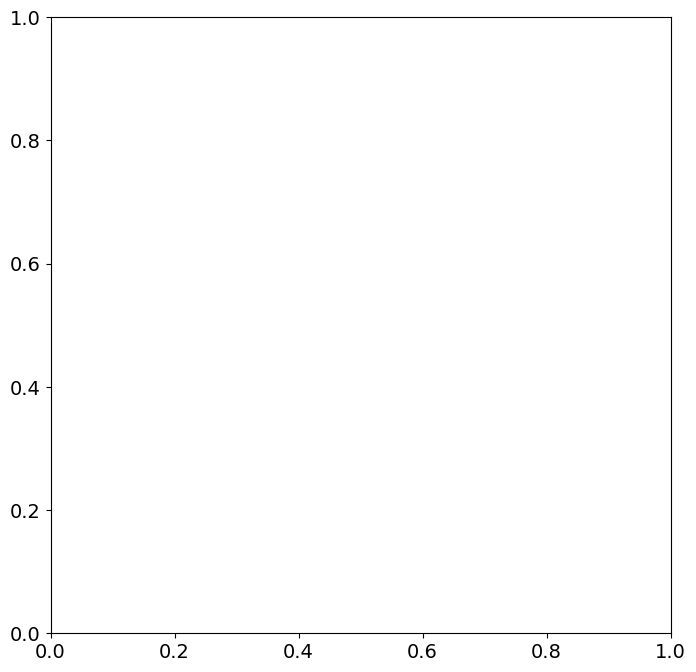

In [16]:
# %%
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Function to create percentile bins, ensuring the column is numeric and handling NaNs
def create_percentile_bins(data, column, n_bins):
    data = data.copy()
    # Convert column to numeric, coerce errors, and drop NaNs
    data[column] = pd.to_numeric(data[column], errors='coerce')
    data = data.dropna(subset=[column])
    data['percentile'] = pd.qcut(data[column], q=n_bins, labels=False, duplicates='drop') + 1
    return data

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

color_palette = sns.color_palette('Set2', len(examples_models_tasks))

is_log = False
plot_var = 'value'
FIGS_PTH = '.'  # Example path
savefile = os.path.join(FIGS_PTH, f"avg_em_by_log_interval_all_log{is_log}_{plot_var}_aligned{ALIGN_THRESH}.pdf")

for i, (model_name, data) in enumerate(examples_models_tasks.items()):
    print(f"name: {model_name}")

    values = data[plot_var].unique()
    if len(values) < 10:
        print(f"Skipping {model_name} due to only one value")
        continue
    else:
        print(f"Values: {values}")

    # Create percentile bins
    n_bins = 20
    data = create_percentile_bins(data, plot_var, n_bins)

    # Calculate average accuracy per percentile bin
    bin_means = data.groupby('percentile').mean().reset_index()

    # Plot the data using the percentile as the x-axis
    ax.plot(bin_means['percentile'], bin_means['accuracy'], color=color_palette[i], label=model_name)

plt.legend()
plt.xlabel('Percentile')
plt.ylabel('Accuracy')
plt.title('Performance vs. Percentile for Different Models')
plt.savefig(savefile)
plt.show()



In [ ]:
# %%
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Function to create percentile bins, ensuring the column is numeric and handling NaNs
def create_percentile_bins(data, column, n_bins):
    data = data.copy()
    # Convert column to numeric, coerce errors, and drop NaNs
    data[column] = pd.to_numeric(data[column], errors='coerce')
    data = data.dropna(subset=[column])
    data['percentile'] = pd.qcut(data[column], q=n_bins, labels=False, duplicates='drop') + 1
    return data

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

color_palette = sns.color_palette('Set2', len(examples_models_tasks))

is_log = False
plot_var = 'value'
FIGS_PTH = '.'  # Example path
ALIGN_THRESH = 1  # Example alignment threshold
savefile = os.path.join(FIGS_PTH, f"avg_em_by_log_interval_all_log{is_log}_{plot_var}_aligned{ALIGN_THRESH}.pdf")

for i, (model_name, data) in enumerate(examples_models_tasks.items()):
    print(f"name: {model_name}")

    values = data[plot_var].unique()
    if len(values) < 10:
        print(f"Skipping {model_name} due to only one value")
        continue
    else:
        print(f"Values: {values}")

    # Create percentile bins
    n_bins = 20
    data = create_percentile_bins(data, plot_var, n_bins)

    # Calculate average accuracy per percentile bin
    bin_means = data.groupby('percentile').mean().reset_index()

    # Plot the data using the percentile as the x-axis
    ax.plot(bin_means['percentile'], bin_means['accuracy'], color=color_palette[i], label=model_name)

plt.legend()
plt.xlabel('Percentile')
plt.ylabel('Accuracy')
plt.title('Performance vs. Percentile for Different Models')
plt.savefig(savefile)
plt.show()



In [ ]:
# %%
question = "What is the medical term for high blood pressure?"
df_q = examples_model[examples_model['question'] == question]
df_q['Q']


In [ ]:
# %%
# from src.utils import normalize_string

# # Apply the function to each row of the DataFrame
# # examples_model[['q_coverage', 'a_coverage']] = examples_model.apply(calculate_qa_coverage, axis=1)

# coverage_df = an.calculate_qa_coverage(examples_model)

# coverage_df['q_coverage'].unique()

# coverage_df[coverage_df['q_coverage'] < 0]


In [ ]:
# %%
is_log = False
plot_var = 'q_coverage'
x_label = 'Question Coverage (p)'

examples_model_cov_int = an.create_bins(coverage_df, plot_var, 
                                        -0.1, 1.0, 5, 
                                        is_log=is_log)

ptqa.plot_variable_by_interval(examples_model_cov_int, log_axis=is_log,
                                x_column='interval', y_column='em',
                                save_pth=savefile, 
                                label='pythia-12b',
                                title=f'Performance vs. {plot_var} for Different Models N={N_GRAMS}',
                                x_label=x_label, 
                                plot_std=True)


In [ ]:
# %%



